# Cross Domain Normalization

In [3]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
trainset_file = '../data/training/w2v_train_data_new.bin'
testset_file = '../data/training/w2v_test_data_new.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/All/unorder1_'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [5]:
trainset = np.load(open(trainset_file, 'rb'))
print('All Train set data size:',len(trainset))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])
print('Good Train set data size:',len(trainset))

testset = np.load(open(testset_file, 'rb'))
print('All Test set data size:', len(testset))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])
print('Good Test set data size:',len(testset))

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

All Train set data size: 59450
Good Train set data size: 59449
All Test set data size: 59507
Good Test set data size: 59507
Number of words: 8242


In [6]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

In [7]:
def stats(test, train, ephocs=100, title=None, params=[50, 100, 150, 200], path=None):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, defult to number of rnn's hidden units.
        
        path: Where to save the graphs image. If none, do not save. 
        '''
    
    ephocs = range(ephocs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test P@1', 'test loss']
    train_Glabels = ['train accuracy', 'train P@1', 'train loss']
    figs = []
    
    
    for j, param in enumerate(params):
        f, P = plt.subplots(1, 3, figsize=(12,4))
       
        for i in range(len(train_Glabels)):
            P[i].plot(ephocs, test_res[j][:,i])
            P[i].plot(ephocs, train_res[j][:,i])
            P[i].legend([test_Glabels[i], train_Glabels[i]], loc=0)
            if title is not None:
                P[i].set_title('%s'%(title))

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train loss %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test loss %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test %s:%.3f'%(metric, max(test_res[j][:,i])))
            P[i].plot()
        plt.show()
        
        if path is not None:
            f.savefig(path+str(params[j])+'_plot.png')
        figs.append(f)
        print('-'*100,'\n')
    return figs

# ALSTM

ALSTM is an LSTM cell that is able to attened over the BBOXes at each timestep

In [8]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # Attention vectors
                 img_attn_states, 
                 # img_attn_idx[i,j]=0 if the i-th vector in img_attn_states
                 # is a padding vector
                 img_attn_idx, 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_out=1.,
                 dropout_in=1.,
                 state_is_tuple=True):
        
        super().__init__(num_units, state_is_tuple=state_is_tuple)
    
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        cell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        
        self.cell = tf.contrib.rnn.DropoutWrapper(
                    cell, output_keep_prob=dropout_out, input_keep_prob=dropout_in)

    def call(self, inputs, state):
        # attention over the BBOXes
        words_attn = self.attention(state[1], self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
        new_input = tf.concat([inputs, words_attn], -1)
        outputs, new_state = self.cell(new_input, state)
        
        return outputs, new_state
    
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            '''
            Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            '''
            # Conv input
            attn_vecs = tf.reshape(
                attn_states, [self.batch_size, self.attn_length, 1, attn_dim]
            )
            # Filter
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            # hidden_attn shape: (batch_size x attn_length x 1 x num_units)
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME") 

            '''
            Computing... hidden_s = U*v_state
            '''
            # Shape: batch_size x 1 x 1 x num_units
            hidden_s = tf.reshape(
                self.linear(tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), 
                [-1, 1, 1,  self.num_units], 
                name='hidden_s'
            )

            '''
            Computing logits...
            '''
            # Shape: batch_size x num_units
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            # a is the weighted sum of the attention vectors (multiplied by the weights (alpha)) 
            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            
            # Project a to num_units dimention
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

In [12]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, # learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether to uses prefix levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 
                 # We scale the VGG16 LN outputs by IMGscale
                 IMGscale=1,
                 # We scale the language LN outputs by Qscale
                 Qscale=1,
                 ):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr
        self.IMGscale=IMGscale
        self.Qscale=Qscale

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a pad (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            if use_wordAttn:
                normed_image = self.IMGscale*tf.contrib.layers.layer_norm(self.img, begin_norm_axis=2)
                attn_vecs = tf.concat([normed_image, self.bboxes], 2) 
                cell = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
            else:
                tmp = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                cell = tf.contrib.rnn.DropoutWrapper(
                    tmp, 
                    input_keep_prob=self.dropout_in, 
                    output_keep_prob=self.dropout_out
                )

            if useBidirectionalRnn:
                if use_wordAttn:
                    cell_bw = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
                else:
                    tmp_bw = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                    cell_bw = tf.contrib.rnn.DropoutWrapper(
                        tmp, 
                        input_keep_prob=self.dropout_in, 
                        output_keep_prob=self.dropout_out
                    )

                    
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell_bw,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                state = tf.concat([self.last_states[0][1], self.last_states[1][1]], -1)
            
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                state = self.last_states[1]

        self.scores = self.CDN_attention(state) 

        # Cross entophy loss for each of the queries in the batch.
        self.loss = tf.reduce_mean(-tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                        axis=-1))
        
        self.g_rnn =  tf.reduce_mean(tf.norm(tf.gradients(self.loss, self.Urnn)[0], axis=1))
        self.g_img =  tf.reduce_mean(
            tf.reduce_sum(
                tf.norm(
                    tf.gradients(self.loss, self.Uatt)[0]+0.0000000001, axis=2), axis=1)/tf.reduce_sum(self.attn_idx, 1))
        

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                        self.global_step,
                                                        decay_steps=decay_steps, 
                                                        decay_rate=decay_rate, 
                                                        staircase=True)

        self.optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.loss, global_step=self.global_step)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

            
    
    
    def CDN_attention(self, q_embed):
        '''
        Given the queries embeddings, calculate the attention over all the query's 
        bounding boxes vectors using CDN, That is, calculate:
        
        probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden), queries embeddings. 
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''

        # Shape: (batch size x num_hidden)
        self.Urnn = self.Qscale*tf.contrib.layers.layer_norm(q_embed) 
        UattTmp = self.IMGscale*tf.contrib.layers.layer_norm(self.img, begin_norm_axis=2)
        self.Uatt = tf.concat([UattTmp, self.bboxes], 2)
        with tf.variable_scope('bnorm_l1') as scope:
            b = tf.get_variable(
                    'b', 
                    initializer=tf.constant_initializer(0.1), 
                    shape=[1, self.num_hidden])

            context = tf.get_variable(
                    'context', 
                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                    shape=[self.num_hidden, 1])


            Sq = tf.nn.dropout(
                self.linear(self.Urnn, self.num_hidden, bias=False, scope='Sq'), 
                self.dropout_q)

            Sattn = tf.nn.dropout(
                        tf.reshape(
                            self.linear(
                                tf.reshape(self.Uatt, (-1, self.img_dims+self.bbox_dims)), 
                                self.num_hidden, 
                                bias=False, scope='Sattn'), 
                             [self.batch_size, -1, self.num_hidden]),
                        self.dropout_img)

            out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
            logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

            # Calculate logits's masked softmax. We use self.attn_idx for 
            # masking the padded BBOXes.
            max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
            masked_logits = tf.exp(logits-max_logits)*self.attn_idx
            probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            return probs
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['p<pad>']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            dist_labels: dist_labels[i][j]=1 if j is the true bbox for query i, else dist_labels[i][j]=0
                        
        '''
                      
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] # data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        dist_labels[[i for i in np.arange(end-start)], [l for l in labels]]=1
        
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), np.array(padded_im), np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, 
               sess=None, feed_dict = None, scores=[]):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(
                    data, start, end)
                    
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx}
                    
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data=None, start=None, end=None, sess=None, 
                     feed_dict=None, threshold=0.5, test=False, scores=[]):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, scores=scores)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, 
                 feed_dict=None, scores=[]):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            loss = 0
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                loss, scores = sess.run([self.loss, self.scores], feed_dict=feed_dict)
                    
            acc = sum(
                np.equal(
                    np.argmax(scores, axis=1), 
                    np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels])
            )
          
        return loss, scores, acc

    def train(self, trn_data, tst_data, ephocs_num,  start_ephoc=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., dropout_q=1.):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc. 
            
            dropout_in: dropout ratio of rnn inputs.
            
            dropout_output: dropout ratio of rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            onlyB: boolean, Wheter to train only B. By setting startA and acctivation_ephoc larger than ephocs_num
                   and setting onlyB to True, we get A out of the game 
                                                  
        '''                  
        
        trn_nbatch = len(trn_data)//self.batch_size
        tst_nbatch = len(tst_data)//self.batch_size
        print('# Train set size:', len(trn_data))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len(tst_data))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res = [], [] # list to hold accuracy and loss of test and train sets
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            qMean_list, qSTD_list, qRange_list, imgMean_list, imgSTD_list, imgRange_list = [], [], [], [], [], []
            Gq, Gimg = [], []
            for ephoc in range(start_ephoc, ephocs_num):
                    
                ############
                # Training #
                ############
                    
                startTime = datetime.now().replace(microsecond=0)   
                print('='*50,'\nTrain, ephoc:',ephoc)
                np.random.shuffle(trn_data)
                trn_loss, trn_acc, trn_iou = 0, 0, 0
                qMean, qSTD, qRange, imgMean, imgSTD, imgRange = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
                g_img, g_rnn = 0.0, 0.0
                
                for b in range(trn_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data, 
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)

                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:dropout_in,
                        self.dropout_out:dropout_out,
                        self.dropout_img:dropout_img,
                        self.dropout_q:dropout_q,
                        self.isTrain:True
                    }
                    
                    g_rnn_tmp, g_img_tmp, scores, Urnn, Uatt, loss, lr, gs,  _ = sess.run([self.g_rnn, 
                                                      self.g_img, self.scores, self.Urnn, self.Uatt, 
                                                        self.loss, self.learning_rate, 
                                                        self.global_step, self.optimizer], feed_dict=feed_dict)
                    
                    Urnn_tmp = np.reshape(Urnn, (-1, 200))
                    qMean_tmp = np.mean(np.mean(Urnn_tmp, axis=0))
                    qSTD_tmp = np.mean(np.std(Urnn_tmp, axis=0))
                    qRange_tmp = np.mean(np.max(Urnn_tmp, axis=0) - np.min(Urnn_tmp, axis=0))
                    
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096)) 
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(Uatt_tmp)
                    
                    # making sure the padds wont be taken into considiration
                    # idx = the raws number that are not paddings in  Uattn
                    attn_idx_tmp = np.reshape(attn_idx, (-1,))
                    idx = [i for j, i in  enumerate(range(len(attn_idx_tmp))) if attn_idx_tmp[j]!=0]
                    #print(sum(attn_idx_tmp), sum(np.sign(idx)))
                    #idx =  np.arange(len(attn_idx_tmp))*attn_idx_tmp
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096))[idx,:]
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(np.mean(Uatt_tmp,0))
                    imgRange_tmp= np.mean(np.max(Uatt_tmp, axis=0) - np.min(imgMean_tmp, axis=0))
                    
                    qMean += qMean_tmp
                    qSTD +=qSTD_tmp
                    qRange += qRange_tmp

                    imgMean += imgMean_tmp
                    imgSTD +=imgSTD_tmp
                    imgRange += imgRange_tmp
                       
                    g_img += g_img_tmp
                    g_rnn += g_rnn_tmp
                    

                    loss, scores, acc = self.accuracy(sess=sess, feed_dict=feed_dict)  
                    iou_acc = self.iou_accuracy(trn_data, b*self.batch_size, (b+1)*self.batch_size,
                                                sess=sess, feed_dict=feed_dict, scores=scores)

                    trn_acc += acc/trn_nbatch
                    trn_loss += loss/trn_nbatch
                    trn_iou += iou_acc/trn_nbatch

                    if b%50==0:
                        print('b:%d'%(b),  
                                ';lr:%.3f'%(lr),
                                ';loss:%.2f'%(loss), ';acc:%.2f'%(acc), 
                                ';iou:%.2f'%(iou_acc),
                                ';qMean:%.2f'%(qMean_tmp),
                                ';qSTD:%.2f'%(qSTD_tmp),
                                ';iMean:%.2f'%(imgMean_tmp),
                                ';iSTD:%.2f'%(imgSTD_tmp),
                                ';qRange:%.2f'%(qRange_tmp),
                                ';iRange:%.2f'%(imgRange_tmp),
                                ';Gq:%.5f'%(g_rnn_tmp*100),
                                ';Gi:%.5f'%(g_img_tmp*100),
                                ';time:', datetime.now().replace(microsecond=0)-startTime)

                print('\n*Tr loss: %.3f'%(trn_loss),';Tr acc: %.3f'%(trn_acc), 
                        ';IOU acc: %.3f'%(trn_iou),  
                        ';qMean:%.3f'%(qMean/trn_nbatch),
                        ';qSTD:%.3f'%(qSTD/trn_nbatch),
                        ';iMean:%.3f'%(imgMean/trn_nbatch),
                        ';iSTD:%.3f'%(imgSTD/trn_nbatch),
                        ';qRange:%.3f'%(qRange/trn_nbatch),
                        ';imgRange:%.3f'%(imgRange/trn_nbatch),
                        ';Gq:%.5f'%(g_rnn*100/trn_nbatch),
                        ';Gi:%.5f'%(g_img*100/trn_nbatch),

                      ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')

                imgMean_list.append(imgMean/trn_nbatch)
                imgSTD_list.append(imgSTD/trn_nbatch)
                qMean_list.append(qMean/trn_nbatch)
                qSTD_list.append(qSTD/trn_nbatch)
                qRange_list.append(qRange/trn_nbatch)
                imgRange_list.append(imgRange/trn_nbatch)
                Gq.append(g_rnn/trn_nbatch)
                Gimg.append(g_img/trn_nbatch)
               
                self.train_res.append([trn_acc, trn_iou, trn_loss])    
                
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)
                
                ###########
                # Testing #
                ###########
                    
                print('Testing, ephoc:',ephoc)
                tstTime = datetime.now().replace(microsecond=0)
                tst_loss, tst_acc, tst_iou = 0, 0, 0
                for b in range(tst_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data,
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)
                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:1.,
                        self.dropout_out:1.,
                        self.dropout_img:1.,
                        self.dropout_q:1.,
                        self.isTrain:False
                    }
                    scores, loss = sess.run([self.scores, self.loss], feed_dict=feed_dict)
                    _,_, acc = self.accuracy(sess=sess, feed_dict=feed_dict, scores=scores)
                    iou_acc = self.iou_accuracy(
                        tst_data, b*self.batch_size, int(b+1)*self.batch_size, sess=sess, 
                        feed_dict=feed_dict, scores=scores)

                    tst_acc += acc/tst_nbatch
                    tst_loss += loss/tst_nbatch
                    tst_iou += iou_acc/tst_nbatch
                    if b%50==0:
                        print('batch:', b, ';loss: %.3f'%(loss), ';acc: %.3f'%(acc), 
                               ';iou_acc: %.3f'%(iou_acc), ';time:', 
                              datetime.now().replace(microsecond=0)-startTime)
                    
                print('\n*Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                      ';Test IOU: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                self.test_res.append([tst_acc, tst_iou, tst_loss])
            print('='*50,'\n')
        return self.test_res, self.train_res, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg


## Random Search

Searching for the best scaling factors

In [41]:
CDN_tst, CDN_trn, CDN_params = [], [], []
scales = np.random.random_sample((5, 2))*(1/40, 0.5)
print('scales:\n',scales, '\n')
for i, scale in enumerate(scales):
    tf.reset_default_graph()
    params_dir = params_dir_tmp+'RL/EXP/CDNsearch_'+str(i)
    m = Model(
        batch_size=200, 
        num_hidden=200,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        Qscale=scale[1],
        IMGscale= scale[0])


    print('params_dir:', params_dir)
    print('Img scale:', scale[0])
    print('Txt scale:', scale[1])
    print('learning rate:', m.lr)

    tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
        trainset, testset, ephocs_num=40)

    CDN_tst.append(tst)
    CDN_trn.append(trn)
    CDN_params.append([scale, imgMean_list, imgSTD_list, imgRange_list, 
                       qMean_list, qSTD_list, qRange_list, Gq, Gimg])
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

scales:
 [[0.01098542 0.08627843]
 [0.00509097 0.37149955]
 [0.01057127 0.44702151]
 [0.01480825 0.48617797]
 [0.00964233 0.24735814]] 

params_dir: ../data/training/models/All/unorder1_RL/EXP/CDNsearch_0
Img scale: 0.010985420973531944
Txt scale: 0.0862784266310096
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.72 ;acc:0.20 ;iou:0.27 ;qMean:-0.00 ;qSTD:0.06 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.32 ;iRange:0.06 ;Gq:0.09257 ;Gi:0.18921 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.64 ;acc:0.26 ;iou:0.34 ;qMean:-0.00 ;qSTD:0.06 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:0.10792 ;Gi:0.19869 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:2.71 ;acc:0.43 ;iou:0.50 ;qMean:-0.00 ;qSTD:0.06 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.33 ;iRange:0.06 ;Gq:0.13771 ;Gi:0.19413 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:2.73 ;acc:0.34 ;iou:0.47 ;qMean:-0.00 ;qSTD:0.07 ;iMean:-0.00 ;iSTD:0.01 ;qRange:

batch: 0 ;loss: 1.430 ;acc: 0.690 ;iou_acc: 0.785 ;time: 0:01:50
batch: 50 ;loss: 1.603 ;acc: 0.590 ;iou_acc: 0.660 ;time: 0:01:57
batch: 100 ;loss: 1.601 ;acc: 0.645 ;iou_acc: 0.740 ;time: 0:02:04
batch: 150 ;loss: 1.688 ;acc: 0.620 ;iou_acc: 0.695 ;time: 0:02:12
batch: 200 ;loss: 1.495 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:02:20
batch: 250 ;loss: 1.654 ;acc: 0.595 ;iou_acc: 0.700 ;time: 0:02:27

*Test loss: 1.546 ;Test accuracy 0.644 ;Test IOU: 0.748 ;Time: 0:02:34
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.32 ;acc:0.73 ;iou:0.82 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.45842 ;Gi:0.67322 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.34 ;acc:0.73 ;iou:0.82 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.46646 ;Gi:0.62342 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.52 ;acc:0.70 ;iou:0.76 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.54800 ;Gi:0.63272 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.63 ;acc:0.60 ;iou:

batch: 0 ;loss: 1.272 ;acc: 0.725 ;iou_acc: 0.825 ;time: 0:01:49
batch: 50 ;loss: 1.413 ;acc: 0.675 ;iou_acc: 0.725 ;time: 0:01:57
batch: 100 ;loss: 1.410 ;acc: 0.695 ;iou_acc: 0.780 ;time: 0:02:04
batch: 150 ;loss: 1.537 ;acc: 0.655 ;iou_acc: 0.730 ;time: 0:02:11
batch: 200 ;loss: 1.345 ;acc: 0.705 ;iou_acc: 0.805 ;time: 0:02:18
batch: 250 ;loss: 1.499 ;acc: 0.640 ;iou_acc: 0.730 ;time: 0:02:25

*Test loss: 1.411 ;Test accuracy 0.679 ;Test IOU: 0.778 ;Time: 0:02:33
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:1.28 ;acc:0.72 ;iou:0.81 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.70690 ;Gi:0.85188 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.30 ;acc:0.70 ;iou:0.79 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.86504 ;Gi:0.83314 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:1.26 ;acc:0.77 ;iou:0.82 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.69349 ;Gi:0.75828 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:1.48 ;acc:0.65 ;iou

batch: 0 ;loss: 1.216 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:01:54
batch: 50 ;loss: 1.382 ;acc: 0.675 ;iou_acc: 0.740 ;time: 0:02:02
batch: 100 ;loss: 1.320 ;acc: 0.740 ;iou_acc: 0.815 ;time: 0:02:09
batch: 150 ;loss: 1.485 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:02:17
batch: 200 ;loss: 1.272 ;acc: 0.705 ;iou_acc: 0.765 ;time: 0:02:26
batch: 250 ;loss: 1.395 ;acc: 0.665 ;iou_acc: 0.750 ;time: 0:02:34

*Test loss: 1.342 ;Test accuracy 0.698 ;Test IOU: 0.793 ;Time: 0:02:41
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:1.28 ;acc:0.72 ;iou:0.79 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.35 ;iRange:0.06 ;Gq:2.01284 ;Gi:1.02332 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.24 ;acc:0.76 ;iou:0.82 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.34 ;iRange:0.06 ;Gq:1.92271 ;Gi:0.96997 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:1.21 ;acc:0.72 ;iou:0.81 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.35 ;iRange:0.06 ;Gq:1.80846 ;Gi:0.99006 ;time: 0:00:39
b:150 ;lr:0.050 ;loss:1.19 ;acc:0.74 ;iou

batch: 0 ;loss: 1.240 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:01:52
batch: 50 ;loss: 1.414 ;acc: 0.680 ;iou_acc: 0.735 ;time: 0:02:00
batch: 100 ;loss: 1.347 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:02:07
batch: 150 ;loss: 1.495 ;acc: 0.645 ;iou_acc: 0.740 ;time: 0:02:15
batch: 200 ;loss: 1.205 ;acc: 0.745 ;iou_acc: 0.835 ;time: 0:02:23
batch: 250 ;loss: 1.456 ;acc: 0.655 ;iou_acc: 0.755 ;time: 0:02:30

*Test loss: 1.331 ;Test accuracy 0.700 ;Test IOU: 0.792 ;Time: 0:02:37
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:1.13 ;acc:0.77 ;iou:0.83 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.36 ;iRange:0.06 ;Gq:1.90225 ;Gi:1.08363 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.23 ;acc:0.71 ;iou:0.81 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.36 ;iRange:0.06 ;Gq:2.03987 ;Gi:1.02806 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:1.13 ;acc:0.74 ;iou:0.82 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.35 ;iRange:0.06 ;Gq:2.08813 ;Gi:1.21906 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.23 ;acc:0.74 ;iou

batch: 0 ;loss: 1.237 ;acc: 0.735 ;iou_acc: 0.825 ;time: 0:01:51
batch: 50 ;loss: 1.457 ;acc: 0.635 ;iou_acc: 0.715 ;time: 0:01:59
batch: 100 ;loss: 1.301 ;acc: 0.730 ;iou_acc: 0.790 ;time: 0:02:06
batch: 150 ;loss: 1.489 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:02:13
batch: 200 ;loss: 1.199 ;acc: 0.750 ;iou_acc: 0.835 ;time: 0:02:21
batch: 250 ;loss: 1.503 ;acc: 0.645 ;iou_acc: 0.735 ;time: 0:02:28

*Test loss: 1.356 ;Test accuracy 0.696 ;Test IOU: 0.788 ;Time: 0:02:35
Train, ephoc: 25
b:0 ;lr:0.050 ;loss:1.25 ;acc:0.74 ;iou:0.81 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.36 ;iRange:0.06 ;Gq:2.24133 ;Gi:1.28678 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.23 ;acc:0.72 ;iou:0.80 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.37 ;iRange:0.06 ;Gq:2.28925 ;Gi:1.45446 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:0.77 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.36 ;iRange:0.06 ;Gq:1.58523 ;Gi:1.11626 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.05 ;acc:0.75 ;iou

batch: 0 ;loss: 1.130 ;acc: 0.730 ;iou_acc: 0.830 ;time: 0:01:49
batch: 50 ;loss: 1.342 ;acc: 0.700 ;iou_acc: 0.785 ;time: 0:01:56
batch: 100 ;loss: 1.209 ;acc: 0.760 ;iou_acc: 0.820 ;time: 0:02:04
batch: 150 ;loss: 1.441 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:02:12
batch: 200 ;loss: 1.146 ;acc: 0.755 ;iou_acc: 0.810 ;time: 0:02:20
batch: 250 ;loss: 1.307 ;acc: 0.675 ;iou_acc: 0.785 ;time: 0:02:28

*Test loss: 1.260 ;Test accuracy 0.721 ;Test IOU: 0.809 ;Time: 0:02:35
Train, ephoc: 30
b:0 ;lr:0.050 ;loss:1.00 ;acc:0.79 ;iou:0.86 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.38 ;iRange:0.06 ;Gq:2.06518 ;Gi:1.39310 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:0.97 ;acc:0.82 ;iou:0.90 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.37 ;iRange:0.06 ;Gq:1.78821 ;Gi:1.40020 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:0.93 ;acc:0.82 ;iou:0.89 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.36 ;iRange:0.06 ;Gq:1.88610 ;Gi:1.56859 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.04 ;acc:0.80 ;iou

batch: 0 ;loss: 1.138 ;acc: 0.720 ;iou_acc: 0.825 ;time: 0:01:52
batch: 50 ;loss: 1.315 ;acc: 0.700 ;iou_acc: 0.780 ;time: 0:01:59
batch: 100 ;loss: 1.223 ;acc: 0.755 ;iou_acc: 0.810 ;time: 0:02:07
batch: 150 ;loss: 1.455 ;acc: 0.665 ;iou_acc: 0.760 ;time: 0:02:15
batch: 200 ;loss: 1.159 ;acc: 0.750 ;iou_acc: 0.815 ;time: 0:02:23
batch: 250 ;loss: 1.321 ;acc: 0.690 ;iou_acc: 0.785 ;time: 0:02:31

*Test loss: 1.260 ;Test accuracy 0.721 ;Test IOU: 0.810 ;Time: 0:02:38
Train, ephoc: 35
b:0 ;lr:0.045 ;loss:1.02 ;acc:0.81 ;iou:0.90 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.38 ;iRange:0.06 ;Gq:2.14327 ;Gi:1.64185 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.73 ;acc:0.87 ;iou:0.92 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.38 ;iRange:0.06 ;Gq:2.09812 ;Gi:1.94864 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:1.00 ;acc:0.76 ;iou:0.82 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.38 ;iRange:0.06 ;Gq:2.30357 ;Gi:1.77745 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.95 ;acc:0.80 ;iou

batch: 0 ;loss: 1.090 ;acc: 0.770 ;iou_acc: 0.860 ;time: 0:01:50
batch: 50 ;loss: 1.282 ;acc: 0.680 ;iou_acc: 0.755 ;time: 0:01:58
batch: 100 ;loss: 1.181 ;acc: 0.760 ;iou_acc: 0.815 ;time: 0:02:05
batch: 150 ;loss: 1.393 ;acc: 0.670 ;iou_acc: 0.760 ;time: 0:02:13
batch: 200 ;loss: 1.047 ;acc: 0.770 ;iou_acc: 0.840 ;time: 0:02:21
batch: 250 ;loss: 1.337 ;acc: 0.695 ;iou_acc: 0.790 ;time: 0:02:29

*Test loss: 1.225 ;Test accuracy 0.732 ;Test IOU: 0.818 ;Time: 0:02:36


****************************************************************************************************
****************************************************************************************************
**************************************************************************************************** 

params_dir: ../data/training/models/All/unorder1_RL/EXP/CDNsearch_1
Img scale: 0.005090969635791093
Txt scale: 0.3714995468238364
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
#

b:150 ;lr:0.050 ;loss:1.36 ;acc:0.69 ;iou:0.80 ;qMean:0.00 ;qSTD:0.28 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.32 ;iRange:0.03 ;Gq:0.62199 ;Gi:0.50910 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.45 ;acc:0.68 ;iou:0.79 ;qMean:0.00 ;qSTD:0.28 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.30 ;iRange:0.03 ;Gq:0.61420 ;Gi:0.54960 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.33 ;acc:0.69 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.31 ;iRange:0.03 ;Gq:0.59473 ;Gi:0.52579 ;time: 0:01:33

*Tr loss: 1.434 ;Tr acc: 0.675 ;IOU acc: 0.774 ;qMean:0.000 ;qSTD:0.281 ;iMean:0.000 ;iSTD:0.005 ;qRange:1.324 ;imgRange:0.029 ;Gq:0.62686 ;Gi:0.55789 ;Time: 0:01:49 

Testing, ephoc: 4
batch: 0 ;loss: 1.405 ;acc: 0.695 ;iou_acc: 0.810 ;time: 0:01:50
batch: 50 ;loss: 1.527 ;acc: 0.650 ;iou_acc: 0.710 ;time: 0:01:57
batch: 100 ;loss: 1.596 ;acc: 0.645 ;iou_acc: 0.745 ;time: 0:02:04
batch: 150 ;loss: 1.630 ;acc: 0.655 ;iou_acc: 0.710 ;time: 0:02:12
batch: 200 ;loss: 1.454 ;acc: 0.650 ;iou_acc: 0.740 ;time: 0:02:19
batch: 

b:100 ;lr:0.050 ;loss:1.07 ;acc:0.78 ;iou:0.86 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.37 ;iRange:0.03 ;Gq:0.60790 ;Gi:0.63010 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:1.37 ;acc:0.66 ;iou:0.76 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.36 ;iRange:0.03 ;Gq:0.68913 ;Gi:0.64430 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.24 ;acc:0.73 ;iou:0.82 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.37 ;iRange:0.03 ;Gq:0.68127 ;Gi:0.68115 ;time: 0:01:13
b:250 ;lr:0.050 ;loss:1.20 ;acc:0.73 ;iou:0.82 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.38 ;iRange:0.03 ;Gq:0.62925 ;Gi:0.66688 ;time: 0:01:32

*Tr loss: 1.298 ;Tr acc: 0.713 ;IOU acc: 0.805 ;qMean:0.001 ;qSTD:0.290 ;iMean:0.000 ;iSTD:0.005 ;qRange:1.362 ;imgRange:0.029 ;Gq:0.68354 ;Gi:0.65386 ;Time: 0:01:48 

Testing, ephoc: 9
batch: 0 ;loss: 1.292 ;acc: 0.675 ;iou_acc: 0.800 ;time: 0:01:49
batch: 50 ;loss: 1.457 ;acc: 0.650 ;iou_acc: 0.720 ;time: 0:01:56
batch: 100 ;loss: 1.473 ;acc: 0.680 ;iou_acc: 0.78

b:50 ;lr:0.050 ;loss:1.26 ;acc:0.73 ;iou:0.80 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.35 ;iRange:0.03 ;Gq:0.75150 ;Gi:0.80278 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.28 ;acc:0.75 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.38 ;iRange:0.03 ;Gq:0.72617 ;Gi:0.73014 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.11 ;acc:0.75 ;iou:0.82 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.35 ;iRange:0.03 ;Gq:0.74770 ;Gi:0.87698 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.19 ;acc:0.74 ;iou:0.82 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.43 ;iRange:0.03 ;Gq:0.76466 ;Gi:0.79681 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.26 ;acc:0.72 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.38 ;iRange:0.03 ;Gq:0.78689 ;Gi:0.79918 ;time: 0:01:33

*Tr loss: 1.209 ;Tr acc: 0.736 ;IOU acc: 0.822 ;qMean:0.001 ;qSTD:0.293 ;iMean:0.000 ;iSTD:0.005 ;qRange:1.382 ;imgRange:0.029 ;Gq:0.73942 ;Gi:0.76560 ;Time: 0:01:49 

Testing, ephoc: 14
batch: 0 ;loss: 1.215 ;

b:0 ;lr:0.050 ;loss:1.17 ;acc:0.77 ;iou:0.82 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.38 ;iRange:0.03 ;Gq:0.84423 ;Gi:0.90514 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.97 ;acc:0.80 ;iou:0.90 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.39 ;iRange:0.03 ;Gq:0.74663 ;Gi:0.88653 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.34 ;acc:0.67 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.39 ;iRange:0.03 ;Gq:0.83519 ;Gi:0.81560 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.26 ;acc:0.73 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.37 ;iRange:0.03 ;Gq:0.83358 ;Gi:0.89126 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.27 ;acc:0.71 ;iou:0.82 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.35 ;iRange:0.03 ;Gq:0.85247 ;Gi:0.96448 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.34 ;acc:0.73 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.37 ;iRange:0.03 ;Gq:0.86753 ;Gi:0.92889 ;time: 0:01:33

*Tr loss: 1.138 ;Tr acc: 0.755 ;IOU acc: 0.838 ;qMean:


*Test loss: 1.343 ;Test accuracy 0.700 ;Test IOU: 0.791 ;Time: 0:02:34
Train, ephoc: 24
b:0 ;lr:0.050 ;loss:1.11 ;acc:0.78 ;iou:0.83 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.42 ;iRange:0.03 ;Gq:0.83465 ;Gi:0.99885 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.95 ;acc:0.82 ;iou:0.90 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.43 ;iRange:0.03 ;Gq:0.78255 ;Gi:0.98368 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.07 ;acc:0.75 ;iou:0.86 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.45 ;iRange:0.03 ;Gq:0.84622 ;Gi:1.12572 ;time: 0:00:39
b:150 ;lr:0.050 ;loss:1.24 ;acc:0.73 ;iou:0.86 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.44 ;iRange:0.03 ;Gq:0.92284 ;Gi:1.02891 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:1.06 ;acc:0.76 ;iou:0.84 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.41 ;iRange:0.03 ;Gq:0.85597 ;Gi:1.14909 ;time: 0:01:15
b:250 ;lr:0.050 ;loss:1.29 ;acc:0.74 ;iou:0.81 ;qMean:0.00 ;qSTD:0.29 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.39 ;iRange:0.03 ;Gq:0

batch: 200 ;loss: 1.300 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:02:19
batch: 250 ;loss: 1.468 ;acc: 0.670 ;iou_acc: 0.810 ;time: 0:02:27

*Test loss: 1.350 ;Test accuracy 0.695 ;Test IOU: 0.787 ;Time: 0:02:34
Train, ephoc: 29
b:0 ;lr:0.050 ;loss:1.08 ;acc:0.80 ;iou:0.85 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.43 ;iRange:0.03 ;Gq:0.86884 ;Gi:1.11778 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.12 ;acc:0.78 ;iou:0.84 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.44 ;iRange:0.03 ;Gq:0.91610 ;Gi:1.21039 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:0.85 ;acc:0.81 ;iou:0.91 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.46 ;iRange:0.03 ;Gq:0.72642 ;Gi:0.92653 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.13 ;acc:0.75 ;iou:0.83 ;qMean:0.00 ;qSTD:0.31 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.45 ;iRange:0.03 ;Gq:0.96489 ;Gi:1.32267 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:0.96 ;acc:0.80 ;iou:0.86 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.44 ;iRange:0.03 ;Gq:0.81848 ;Gi:0.99156 ;time

batch: 100 ;loss: 1.318 ;acc: 0.740 ;iou_acc: 0.800 ;time: 0:02:05
batch: 150 ;loss: 1.521 ;acc: 0.660 ;iou_acc: 0.740 ;time: 0:02:13
batch: 200 ;loss: 1.213 ;acc: 0.720 ;iou_acc: 0.825 ;time: 0:02:21
batch: 250 ;loss: 1.496 ;acc: 0.640 ;iou_acc: 0.730 ;time: 0:02:28

*Test loss: 1.308 ;Test accuracy 0.711 ;Test IOU: 0.800 ;Time: 0:02:36
Train, ephoc: 34
b:0 ;lr:0.045 ;loss:0.97 ;acc:0.78 ;iou:0.86 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.46 ;iRange:0.03 ;Gq:0.90390 ;Gi:1.25255 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.87 ;acc:0.83 ;iou:0.91 ;qMean:0.00 ;qSTD:0.31 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.46 ;iRange:0.03 ;Gq:0.88944 ;Gi:1.23489 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:1.27 ;acc:0.74 ;iou:0.80 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.45 ;iRange:0.03 ;Gq:1.11050 ;Gi:1.52024 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:1.02 ;acc:0.78 ;iou:0.86 ;qMean:0.00 ;qSTD:0.31 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.49 ;iRange:0.03 ;Gq:0.90672 ;Gi:1.33002 ;time: 0:00:55
b:200 ;lr:0.04

batch: 0 ;loss: 1.136 ;acc: 0.770 ;iou_acc: 0.865 ;time: 0:01:49
batch: 50 ;loss: 1.456 ;acc: 0.685 ;iou_acc: 0.770 ;time: 0:01:57
batch: 100 ;loss: 1.331 ;acc: 0.710 ;iou_acc: 0.795 ;time: 0:02:04
batch: 150 ;loss: 1.549 ;acc: 0.700 ;iou_acc: 0.780 ;time: 0:02:11
batch: 200 ;loss: 1.164 ;acc: 0.700 ;iou_acc: 0.800 ;time: 0:02:19
batch: 250 ;loss: 1.488 ;acc: 0.655 ;iou_acc: 0.760 ;time: 0:02:26

*Test loss: 1.327 ;Test accuracy 0.710 ;Test IOU: 0.799 ;Time: 0:02:33
Train, ephoc: 39
b:0 ;lr:0.045 ;loss:0.89 ;acc:0.84 ;iou:0.89 ;qMean:0.00 ;qSTD:0.30 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.49 ;iRange:0.03 ;Gq:0.88063 ;Gi:1.34694 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:1.13 ;acc:0.72 ;iou:0.81 ;qMean:0.00 ;qSTD:0.31 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.49 ;iRange:0.03 ;Gq:1.15580 ;Gi:1.65918 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:1.01 ;acc:0.78 ;iou:0.86 ;qMean:0.00 ;qSTD:0.31 ;iMean:0.00 ;iSTD:0.00 ;qRange:1.50 ;iRange:0.03 ;Gq:0.93146 ;Gi:1.27798 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.93 ;acc:0.80 ;iou

b:150 ;lr:0.050 ;loss:1.40 ;acc:0.64 ;iou:0.76 ;qMean:-0.00 ;qSTD:0.34 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.60 ;iRange:0.06 ;Gq:0.51160 ;Gi:0.53604 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:1.39 ;acc:0.71 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.33 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.58 ;iRange:0.06 ;Gq:0.57911 ;Gi:0.57862 ;time: 0:01:16
b:250 ;lr:0.050 ;loss:1.50 ;acc:0.66 ;iou:0.77 ;qMean:-0.00 ;qSTD:0.32 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.55 ;iRange:0.06 ;Gq:0.56933 ;Gi:0.47967 ;time: 0:01:35

*Tr loss: 1.468 ;Tr acc: 0.663 ;IOU acc: 0.766 ;qMean:-0.000 ;qSTD:0.335 ;iMean:0.000 ;iSTD:0.010 ;qRange:1.586 ;imgRange:0.059 ;Gq:0.54266 ;Gi:0.52493 ;Time: 0:01:52 

Testing, ephoc: 3
batch: 0 ;loss: 1.437 ;acc: 0.655 ;iou_acc: 0.780 ;time: 0:01:52
batch: 50 ;loss: 1.604 ;acc: 0.615 ;iou_acc: 0.695 ;time: 0:01:59
batch: 100 ;loss: 1.687 ;acc: 0.630 ;iou_acc: 0.720 ;time: 0:02:07
batch: 150 ;loss: 1.682 ;acc: 0.625 ;iou_acc: 0.710 ;time: 0:02:15
batch: 200 ;loss: 1.573 ;acc: 0.605 ;iou_acc: 0.705 ;time: 0:02:22
bat

b:100 ;lr:0.050 ;loss:1.35 ;acc:0.70 ;iou:0.79 ;qMean:-0.00 ;qSTD:0.34 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.59 ;iRange:0.06 ;Gq:0.59325 ;Gi:0.65443 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.22 ;acc:0.75 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.60 ;iRange:0.06 ;Gq:0.56523 ;Gi:0.59625 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:1.40 ;acc:0.64 ;iou:0.75 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.64 ;iRange:0.06 ;Gq:0.66416 ;Gi:0.70785 ;time: 0:01:16
b:250 ;lr:0.050 ;loss:1.25 ;acc:0.70 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.34 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.62 ;iRange:0.06 ;Gq:0.56555 ;Gi:0.62904 ;time: 0:01:34

*Tr loss: 1.279 ;Tr acc: 0.718 ;IOU acc: 0.808 ;qMean:-0.000 ;qSTD:0.346 ;iMean:0.000 ;iSTD:0.010 ;qRange:1.621 ;imgRange:0.059 ;Gq:0.60626 ;Gi:0.66547 ;Time: 0:01:52 

Testing, ephoc: 8
batch: 0 ;loss: 1.219 ;acc: 0.725 ;iou_acc: 0.840 ;time: 0:01:52
batch: 50 ;loss: 1.426 ;acc: 0.675 ;iou_acc: 0.755 ;time: 0:01:59
batch: 100 ;loss: 1.437 ;acc: 0.705 ;iou_acc:

b:50 ;lr:0.050 ;loss:1.31 ;acc:0.74 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.66 ;iRange:0.06 ;Gq:0.71391 ;Gi:0.96216 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.24 ;acc:0.74 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.64 ;iRange:0.06 ;Gq:0.68513 ;Gi:0.75432 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.28 ;acc:0.76 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.67 ;iRange:0.06 ;Gq:0.70979 ;Gi:0.81699 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.12 ;acc:0.75 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.67 ;iRange:0.06 ;Gq:0.60650 ;Gi:0.83187 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.01 ;acc:0.77 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.65 ;iRange:0.06 ;Gq:0.64772 ;Gi:0.76304 ;time: 0:01:32

*Tr loss: 1.166 ;Tr acc: 0.748 ;IOU acc: 0.833 ;qMean:-0.000 ;qSTD:0.352 ;iMean:0.000 ;iSTD:0.010 ;qRange:1.650 ;imgRange:0.059 ;Gq:0.65706 ;Gi:0.81444 ;Time: 0:01:49 

Testing, ephoc: 13
batch: 0 ;loss: 1

b:0 ;lr:0.050 ;loss:1.15 ;acc:0.76 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.66 ;iRange:0.06 ;Gq:0.68637 ;Gi:0.99053 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.11 ;acc:0.79 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.64 ;iRange:0.06 ;Gq:0.68681 ;Gi:0.87407 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.21 ;acc:0.72 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.72 ;iRange:0.06 ;Gq:0.78904 ;Gi:1.16044 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.14 ;acc:0.75 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.67 ;iRange:0.06 ;Gq:0.71811 ;Gi:0.98189 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.00 ;acc:0.79 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.71 ;iRange:0.06 ;Gq:0.69779 ;Gi:0.90177 ;time: 0:01:13
b:250 ;lr:0.050 ;loss:1.16 ;acc:0.74 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.66 ;iRange:0.06 ;Gq:0.81545 ;Gi:1.07440 ;time: 0:01:31

*Tr loss: 1.076 ;Tr acc: 0.771 ;IOU acc: 0.850 ;


*Test loss: 1.281 ;Test accuracy 0.712 ;Test IOU: 0.801 ;Time: 0:02:33
Train, ephoc: 23
b:0 ;lr:0.050 ;loss:0.92 ;acc:0.82 ;iou:0.86 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.70 ;iRange:0.06 ;Gq:0.68519 ;Gi:1.03011 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.02 ;acc:0.80 ;iou:0.86 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.67 ;iRange:0.06 ;Gq:0.75422 ;Gi:1.06466 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.00 ;acc:0.80 ;iou:0.90 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.72 ;iRange:0.06 ;Gq:0.71438 ;Gi:1.02880 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.09 ;acc:0.77 ;iou:0.85 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.69 ;iRange:0.06 ;Gq:0.74522 ;Gi:1.03663 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:0.88 ;acc:0.83 ;iou:0.92 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.74 ;iRange:0.06 ;Gq:0.69071 ;Gi:1.19330 ;time: 0:01:15
b:250 ;lr:0.050 ;loss:1.10 ;acc:0.75 ;iou:0.84 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.73 ;iRange:0.06 ;Gq:0

batch: 200 ;loss: 1.198 ;acc: 0.710 ;iou_acc: 0.790 ;time: 0:02:21
batch: 250 ;loss: 1.384 ;acc: 0.665 ;iou_acc: 0.810 ;time: 0:02:29

*Test loss: 1.261 ;Test accuracy 0.719 ;Test IOU: 0.808 ;Time: 0:02:36
Train, ephoc: 28
b:0 ;lr:0.050 ;loss:0.88 ;acc:0.82 ;iou:0.90 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.72 ;iRange:0.06 ;Gq:0.73016 ;Gi:1.18214 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.84 ;acc:0.79 ;iou:0.88 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.70 ;iRange:0.06 ;Gq:0.70330 ;Gi:1.15322 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:0.80 ;acc:0.83 ;iou:0.90 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.73 ;iRange:0.06 ;Gq:0.72932 ;Gi:1.10105 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:0.91 ;acc:0.81 ;iou:0.88 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.74 ;iRange:0.06 ;Gq:0.82114 ;Gi:1.31226 ;time: 0:00:54
b:200 ;lr:0.050 ;loss:0.83 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.72 ;iRange:0.06 ;Gq:0.76404 ;Gi:1.28088 ;time

batch: 100 ;loss: 1.242 ;acc: 0.755 ;iou_acc: 0.805 ;time: 0:02:07
batch: 150 ;loss: 1.440 ;acc: 0.690 ;iou_acc: 0.745 ;time: 0:02:15
batch: 200 ;loss: 1.112 ;acc: 0.730 ;iou_acc: 0.825 ;time: 0:02:23
batch: 250 ;loss: 1.368 ;acc: 0.715 ;iou_acc: 0.810 ;time: 0:02:30

*Test loss: 1.252 ;Test accuracy 0.724 ;Test IOU: 0.809 ;Time: 0:02:37
Train, ephoc: 33
b:0 ;lr:0.050 ;loss:0.87 ;acc:0.85 ;iou:0.90 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.79 ;iRange:0.06 ;Gq:0.77415 ;Gi:1.28632 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:0.86 ;acc:0.82 ;iou:0.90 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.75 ;iRange:0.06 ;Gq:0.79128 ;Gi:1.25069 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:0.88 ;acc:0.83 ;iou:0.91 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.77 ;iRange:0.06 ;Gq:0.75818 ;Gi:1.29359 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:0.81 ;acc:0.84 ;iou:0.92 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.75 ;iRange:0.06 ;Gq:0.78660 ;Gi:1.33393 ;time: 0:00:55
b:200 ;lr:0.04

batch: 0 ;loss: 1.059 ;acc: 0.780 ;iou_acc: 0.870 ;time: 0:01:50
batch: 50 ;loss: 1.281 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:01:57
batch: 100 ;loss: 1.233 ;acc: 0.755 ;iou_acc: 0.820 ;time: 0:02:05
batch: 150 ;loss: 1.408 ;acc: 0.690 ;iou_acc: 0.750 ;time: 0:02:12
batch: 200 ;loss: 1.101 ;acc: 0.785 ;iou_acc: 0.845 ;time: 0:02:20
batch: 250 ;loss: 1.356 ;acc: 0.705 ;iou_acc: 0.805 ;time: 0:02:27

*Test loss: 1.236 ;Test accuracy 0.730 ;Test IOU: 0.816 ;Time: 0:02:34
Train, ephoc: 38
b:0 ;lr:0.045 ;loss:0.92 ;acc:0.79 ;iou:0.91 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.75 ;iRange:0.06 ;Gq:0.88785 ;Gi:1.64489 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.85 ;acc:0.82 ;iou:0.88 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.79 ;iRange:0.06 ;Gq:0.73636 ;Gi:1.27797 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.99 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.80 ;iRange:0.06 ;Gq:0.93458 ;Gi:1.59495 ;time: 0:00:36
b:150 ;lr:0.045 ;loss:0.91 ;acc:0.83 ;iou

b:150 ;lr:0.050 ;loss:1.52 ;acc:0.63 ;iou:0.72 ;qMean:0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.69 ;iRange:0.08 ;Gq:0.53850 ;Gi:0.47606 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.35 ;acc:0.72 ;iou:0.79 ;qMean:0.00 ;qSTD:0.35 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.67 ;iRange:0.08 ;Gq:0.54448 ;Gi:0.55962 ;time: 0:01:15
b:250 ;lr:0.050 ;loss:1.41 ;acc:0.69 ;iou:0.79 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.69 ;iRange:0.08 ;Gq:0.49995 ;Gi:0.46489 ;time: 0:01:33

*Tr loss: 1.537 ;Tr acc: 0.645 ;IOU acc: 0.747 ;qMean:0.000 ;qSTD:0.350 ;iMean:0.000 ;iSTD:0.014 ;qRange:1.678 ;imgRange:0.083 ;Gq:0.50838 ;Gi:0.50539 ;Time: 0:01:50 

Testing, ephoc: 2
batch: 0 ;loss: 1.499 ;acc: 0.655 ;iou_acc: 0.750 ;time: 0:01:51
batch: 50 ;loss: 1.665 ;acc: 0.620 ;iou_acc: 0.650 ;time: 0:01:58
batch: 100 ;loss: 1.689 ;acc: 0.630 ;iou_acc: 0.720 ;time: 0:02:06
batch: 150 ;loss: 1.664 ;acc: 0.640 ;iou_acc: 0.720 ;time: 0:02:14
batch: 200 ;loss: 1.557 ;acc: 0.635 ;iou_acc: 0.720 ;time: 0:02:21
batch: 

b:100 ;lr:0.050 ;loss:1.24 ;acc:0.72 ;iou:0.80 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.72 ;iRange:0.08 ;Gq:0.57950 ;Gi:0.57666 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.34 ;acc:0.71 ;iou:0.81 ;qMean:0.00 ;qSTD:0.36 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.73 ;iRange:0.08 ;Gq:0.57520 ;Gi:0.66262 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.30 ;acc:0.71 ;iou:0.81 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.73 ;iRange:0.08 ;Gq:0.57697 ;Gi:0.62311 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.26 ;acc:0.72 ;iou:0.80 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.76 ;iRange:0.08 ;Gq:0.59168 ;Gi:0.64590 ;time: 0:01:32

*Tr loss: 1.277 ;Tr acc: 0.718 ;IOU acc: 0.808 ;qMean:0.001 ;qSTD:0.370 ;iMean:0.000 ;iSTD:0.014 ;qRange:1.735 ;imgRange:0.083 ;Gq:0.58372 ;Gi:0.63967 ;Time: 0:01:50 

Testing, ephoc: 7
batch: 0 ;loss: 1.290 ;acc: 0.755 ;iou_acc: 0.840 ;time: 0:01:50
batch: 50 ;loss: 1.480 ;acc: 0.655 ;iou_acc: 0.720 ;time: 0:01:57
batch: 100 ;loss: 1.512 ;acc: 0.685 ;iou_acc: 0.74

b:50 ;lr:0.050 ;loss:1.16 ;acc:0.75 ;iou:0.83 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.77 ;iRange:0.08 ;Gq:0.66054 ;Gi:0.85011 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:1.15 ;acc:0.76 ;iou:0.86 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.77 ;iRange:0.08 ;Gq:0.60497 ;Gi:0.72849 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.14 ;acc:0.77 ;iou:0.88 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.80 ;iRange:0.08 ;Gq:0.59977 ;Gi:0.80337 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:1.11 ;acc:0.75 ;iou:0.84 ;qMean:0.00 ;qSTD:0.37 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.78 ;iRange:0.08 ;Gq:0.60081 ;Gi:0.76524 ;time: 0:01:16
b:250 ;lr:0.050 ;loss:1.20 ;acc:0.71 ;iou:0.81 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.77 ;iRange:0.08 ;Gq:0.70942 ;Gi:0.89537 ;time: 0:01:34

*Tr loss: 1.145 ;Tr acc: 0.754 ;IOU acc: 0.835 ;qMean:0.001 ;qSTD:0.379 ;iMean:0.000 ;iSTD:0.014 ;qRange:1.779 ;imgRange:0.083 ;Gq:0.63228 ;Gi:0.77116 ;Time: 0:01:50 

Testing, ephoc: 12
batch: 0 ;loss: 1.147 ;

b:0 ;lr:0.050 ;loss:1.02 ;acc:0.78 ;iou:0.86 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.77 ;iRange:0.08 ;Gq:0.62526 ;Gi:0.88198 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.23 ;acc:0.70 ;iou:0.79 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.80 ;iRange:0.08 ;Gq:0.72804 ;Gi:0.99839 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.06 ;acc:0.79 ;iou:0.86 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.83 ;iRange:0.08 ;Gq:0.65401 ;Gi:0.93057 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.16 ;acc:0.74 ;iou:0.83 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.79 ;iRange:0.08 ;Gq:0.69073 ;Gi:0.85368 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.10 ;acc:0.75 ;iou:0.82 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.79 ;iRange:0.08 ;Gq:0.75543 ;Gi:0.96750 ;time: 0:01:15
b:250 ;lr:0.050 ;loss:0.94 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.81 ;iRange:0.08 ;Gq:0.63528 ;Gi:0.91887 ;time: 0:01:33

*Tr loss: 1.049 ;Tr acc: 0.779 ;IOU acc: 0.855 ;qMean:


*Test loss: 1.269 ;Test accuracy 0.716 ;Test IOU: 0.803 ;Time: 0:02:33
Train, ephoc: 22
b:0 ;lr:0.050 ;loss:0.93 ;acc:0.82 ;iou:0.89 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.81 ;iRange:0.08 ;Gq:0.66791 ;Gi:0.92894 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.89 ;acc:0.82 ;iou:0.88 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.82 ;iRange:0.08 ;Gq:0.68449 ;Gi:0.94548 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:0.85 ;acc:0.82 ;iou:0.91 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.81 ;iRange:0.08 ;Gq:0.64633 ;Gi:0.97913 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:0.93 ;acc:0.84 ;iou:0.89 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.83 ;iRange:0.08 ;Gq:0.65225 ;Gi:1.00616 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:0.91 ;acc:0.82 ;iou:0.87 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.82 ;iRange:0.08 ;Gq:0.73259 ;Gi:1.02297 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:0.92 ;acc:0.82 ;iou:0.88 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.84 ;iRange:0.08 ;Gq:0

batch: 200 ;loss: 1.130 ;acc: 0.800 ;iou_acc: 0.870 ;time: 0:02:20
batch: 250 ;loss: 1.398 ;acc: 0.675 ;iou_acc: 0.795 ;time: 0:02:28

*Test loss: 1.244 ;Test accuracy 0.729 ;Test IOU: 0.815 ;Time: 0:02:35
Train, ephoc: 27
b:0 ;lr:0.050 ;loss:0.98 ;acc:0.82 ;iou:0.86 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.86 ;iRange:0.08 ;Gq:0.78606 ;Gi:1.27895 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.88 ;acc:0.81 ;iou:0.91 ;qMean:0.00 ;qSTD:0.38 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.84 ;iRange:0.08 ;Gq:0.76448 ;Gi:1.18795 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:0.99 ;acc:0.79 ;iou:0.85 ;qMean:0.00 ;qSTD:0.39 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.86 ;iRange:0.08 ;Gq:0.74729 ;Gi:1.24109 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:0.80 ;acc:0.85 ;iou:0.90 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.88 ;iRange:0.08 ;Gq:0.73559 ;Gi:1.17233 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:0.89 ;acc:0.82 ;iou:0.90 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.86 ;iRange:0.08 ;Gq:0.68098 ;Gi:1.08711 ;time

batch: 100 ;loss: 1.236 ;acc: 0.755 ;iou_acc: 0.800 ;time: 0:02:04
batch: 150 ;loss: 1.498 ;acc: 0.705 ;iou_acc: 0.765 ;time: 0:02:11
batch: 200 ;loss: 1.126 ;acc: 0.735 ;iou_acc: 0.820 ;time: 0:02:19
batch: 250 ;loss: 1.361 ;acc: 0.700 ;iou_acc: 0.785 ;time: 0:02:27

*Test loss: 1.211 ;Test accuracy 0.737 ;Test IOU: 0.821 ;Time: 0:02:34
Train, ephoc: 32
b:0 ;lr:0.050 ;loss:0.87 ;acc:0.83 ;iou:0.91 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.89 ;iRange:0.08 ;Gq:0.76601 ;Gi:1.34859 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.82 ;acc:0.82 ;iou:0.88 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.87 ;iRange:0.08 ;Gq:0.72340 ;Gi:1.31798 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:0.76 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.88 ;iRange:0.08 ;Gq:0.78189 ;Gi:1.37537 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:0.78 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.90 ;iRange:0.08 ;Gq:0.64040 ;Gi:1.11183 ;time: 0:00:56
b:200 ;lr:0.05

batch: 0 ;loss: 1.001 ;acc: 0.755 ;iou_acc: 0.825 ;time: 0:01:49
batch: 50 ;loss: 1.356 ;acc: 0.680 ;iou_acc: 0.785 ;time: 0:01:56
batch: 100 ;loss: 1.171 ;acc: 0.755 ;iou_acc: 0.810 ;time: 0:02:04
batch: 150 ;loss: 1.429 ;acc: 0.725 ;iou_acc: 0.795 ;time: 0:02:12
batch: 200 ;loss: 1.141 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:02:19
batch: 250 ;loss: 1.350 ;acc: 0.710 ;iou_acc: 0.815 ;time: 0:02:27

*Test loss: 1.228 ;Test accuracy 0.737 ;Test IOU: 0.820 ;Time: 0:02:34
Train, ephoc: 37
b:0 ;lr:0.045 ;loss:0.83 ;acc:0.85 ;iou:0.92 ;qMean:0.00 ;qSTD:0.41 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.92 ;iRange:0.08 ;Gq:0.74427 ;Gi:1.15437 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.65 ;acc:0.88 ;iou:0.94 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.89 ;iRange:0.08 ;Gq:0.66635 ;Gi:1.30551 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.68 ;acc:0.88 ;iou:0.92 ;qMean:0.00 ;qSTD:0.40 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.90 ;iRange:0.08 ;Gq:0.73686 ;Gi:1.35666 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.81 ;acc:0.85 ;iou

b:150 ;lr:0.050 ;loss:1.70 ;acc:0.63 ;iou:0.72 ;qMean:-0.00 ;qSTD:0.21 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.99 ;iRange:0.05 ;Gq:0.59566 ;Gi:0.49371 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.83 ;acc:0.54 ;iou:0.67 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05 ;Gq:0.64712 ;Gi:0.47003 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.54 ;acc:0.64 ;iou:0.72 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05 ;Gq:0.58813 ;Gi:0.44475 ;time: 0:01:33

*Tr loss: 1.768 ;Tr acc: 0.595 ;IOU acc: 0.704 ;qMean:-0.000 ;qSTD:0.203 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.990 ;imgRange:0.054 ;Gq:0.57349 ;Gi:0.47226 ;Time: 0:01:50 

Testing, ephoc: 1
batch: 0 ;loss: 1.549 ;acc: 0.640 ;iou_acc: 0.770 ;time: 0:01:50
batch: 50 ;loss: 1.741 ;acc: 0.595 ;iou_acc: 0.650 ;time: 0:01:57
batch: 100 ;loss: 1.700 ;acc: 0.635 ;iou_acc: 0.735 ;time: 0:02:05
batch: 150 ;loss: 1.769 ;acc: 0.655 ;iou_acc: 0.720 ;time: 0:02:12
batch: 200 ;loss: 1.611 ;acc: 0.635 ;iou_acc: 0.725 ;time: 0:02:19
bat

b:100 ;lr:0.050 ;loss:1.39 ;acc:0.72 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.88 ;iRange:0.05 ;Gq:0.84933 ;Gi:0.71232 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.36 ;acc:0.71 ;iou:0.77 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.90 ;iRange:0.05 ;Gq:0.88498 ;Gi:0.67812 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.28 ;acc:0.75 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.92 ;iRange:0.05 ;Gq:0.79429 ;Gi:0.61860 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.27 ;acc:0.72 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.88 ;iRange:0.05 ;Gq:0.80068 ;Gi:0.67562 ;time: 0:01:32

*Tr loss: 1.359 ;Tr acc: 0.696 ;IOU acc: 0.790 ;qMean:-0.000 ;qSTD:0.191 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.900 ;imgRange:0.054 ;Gq:0.83630 ;Gi:0.65213 ;Time: 0:01:49 

Testing, ephoc: 6
batch: 0 ;loss: 1.297 ;acc: 0.720 ;iou_acc: 0.840 ;time: 0:01:49
batch: 50 ;loss: 1.428 ;acc: 0.665 ;iou_acc: 0.715 ;time: 0:01:56
batch: 100 ;loss: 1.501 ;acc: 0.710 ;iou_acc:

b:50 ;lr:0.050 ;loss:1.24 ;acc:0.71 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.93 ;iRange:0.05 ;Gq:0.94482 ;Gi:0.81200 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.09 ;acc:0.77 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.91 ;iRange:0.05 ;Gq:0.93080 ;Gi:0.81128 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:1.37 ;acc:0.73 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.92 ;iRange:0.05 ;Gq:1.00281 ;Gi:0.88535 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:1.10 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.93 ;iRange:0.05 ;Gq:0.87931 ;Gi:0.81011 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.21 ;acc:0.70 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.91 ;iRange:0.05 ;Gq:0.85423 ;Gi:0.78845 ;time: 0:01:34

*Tr loss: 1.234 ;Tr acc: 0.731 ;IOU acc: 0.819 ;qMean:-0.000 ;qSTD:0.195 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.918 ;imgRange:0.054 ;Gq:0.92109 ;Gi:0.79618 ;Time: 0:01:50 

Testing, ephoc: 11
batch: 0 ;loss: 1

b:0 ;lr:0.050 ;loss:1.24 ;acc:0.73 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.19 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.92 ;iRange:0.05 ;Gq:0.97421 ;Gi:0.97425 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.16 ;acc:0.73 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.94 ;iRange:0.05 ;Gq:0.93879 ;Gi:0.85774 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:1.18 ;acc:0.73 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.93 ;iRange:0.05 ;Gq:0.94865 ;Gi:0.90424 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:1.30 ;acc:0.72 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.92 ;iRange:0.05 ;Gq:1.02512 ;Gi:0.99020 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.01 ;acc:0.79 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:0.90935 ;Gi:0.93889 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.05 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.93 ;iRange:0.05 ;Gq:0.91775 ;Gi:0.91205 ;time: 0:01:32

*Tr loss: 1.139 ;Tr acc: 0.753 ;IOU acc: 0.836 ;


*Test loss: 1.317 ;Test accuracy 0.702 ;Test IOU: 0.795 ;Time: 0:02:37
Train, ephoc: 21
b:0 ;lr:0.050 ;loss:0.92 ;acc:0.81 ;iou:0.88 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.94 ;iRange:0.05 ;Gq:0.98503 ;Gi:0.98674 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.96 ;acc:0.83 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05 ;Gq:0.96074 ;Gi:0.98927 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.10 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:1.10454 ;Gi:1.07427 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:1.07 ;acc:0.76 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:1.11287 ;Gi:1.12796 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:1.08 ;acc:0.74 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:1.11296 ;Gi:1.05278 ;time: 0:01:12
b:250 ;lr:0.050 ;loss:1.29 ;acc:0.74 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05

batch: 150 ;loss: 1.528 ;acc: 0.660 ;iou_acc: 0.725 ;time: 0:02:12
batch: 200 ;loss: 1.198 ;acc: 0.735 ;iou_acc: 0.840 ;time: 0:02:20
batch: 250 ;loss: 1.439 ;acc: 0.660 ;iou_acc: 0.750 ;time: 0:02:28

*Test loss: 1.285 ;Test accuracy 0.713 ;Test IOU: 0.801 ;Time: 0:02:35
Train, ephoc: 26
b:0 ;lr:0.050 ;loss:0.87 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:0.92117 ;Gi:0.99766 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:0.89 ;acc:0.84 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.98 ;iRange:0.05 ;Gq:1.08364 ;Gi:1.22445 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:1.01 ;acc:0.78 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.95 ;iRange:0.05 ;Gq:1.01138 ;Gi:1.19844 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:0.85 ;acc:0.84 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.21 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05 ;Gq:0.98341 ;Gi:1.08534 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:0.94 ;acc:0.81 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.20 ;iMean

batch: 0 ;loss: 1.060 ;acc: 0.785 ;iou_acc: 0.855 ;time: 0:01:50
batch: 50 ;loss: 1.224 ;acc: 0.715 ;iou_acc: 0.800 ;time: 0:01:58
batch: 100 ;loss: 1.214 ;acc: 0.775 ;iou_acc: 0.815 ;time: 0:02:05
batch: 150 ;loss: 1.476 ;acc: 0.715 ;iou_acc: 0.775 ;time: 0:02:13
batch: 200 ;loss: 1.180 ;acc: 0.730 ;iou_acc: 0.820 ;time: 0:02:21
batch: 250 ;loss: 1.329 ;acc: 0.705 ;iou_acc: 0.775 ;time: 0:02:28

*Test loss: 1.251 ;Test accuracy 0.721 ;Test IOU: 0.808 ;Time: 0:02:35
Train, ephoc: 31
b:0 ;lr:0.050 ;loss:0.94 ;acc:0.82 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.96 ;iRange:0.05 ;Gq:1.07789 ;Gi:1.20539 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.04 ;acc:0.77 ;iou:0.87 ;qMean:0.00 ;qSTD:0.20 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.98 ;iRange:0.05 ;Gq:1.28697 ;Gi:1.47150 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.05 ;acc:0.77 ;iou:0.85 ;qMean:0.00 ;qSTD:0.21 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.97 ;iRange:0.05 ;Gq:1.14737 ;Gi:1.30019 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:0.97 ;acc:0.81 ;io

batch: 0 ;loss: 1.029 ;acc: 0.770 ;iou_acc: 0.850 ;time: 0:01:50
batch: 50 ;loss: 1.228 ;acc: 0.730 ;iou_acc: 0.800 ;time: 0:01:58
batch: 100 ;loss: 1.203 ;acc: 0.775 ;iou_acc: 0.840 ;time: 0:02:05
batch: 150 ;loss: 1.484 ;acc: 0.695 ;iou_acc: 0.765 ;time: 0:02:13
batch: 200 ;loss: 1.170 ;acc: 0.755 ;iou_acc: 0.825 ;time: 0:02:21
batch: 250 ;loss: 1.368 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:02:28

*Test loss: 1.237 ;Test accuracy 0.728 ;Test IOU: 0.814 ;Time: 0:02:35
Train, ephoc: 36
b:0 ;lr:0.045 ;loss:0.91 ;acc:0.80 ;iou:0.88 ;qMean:0.00 ;qSTD:0.22 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.02 ;iRange:0.05 ;Gq:1.15114 ;Gi:1.52822 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.71 ;acc:0.85 ;iou:0.92 ;qMean:0.00 ;qSTD:0.21 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.00 ;iRange:0.05 ;Gq:0.97057 ;Gi:1.33992 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:0.74 ;acc:0.86 ;iou:0.94 ;qMean:0.00 ;qSTD:0.21 ;iMean:0.00 ;iSTD:0.01 ;qRange:1.01 ;iRange:0.05 ;Gq:1.04044 ;Gi:1.35444 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.97 ;acc:0.76 ;iou

Train accuracy:0.812
Test accuracy:0.732
Train IOU:0.880
Test IOU:0.818
Train loss loss:0.912
Test loss loss:1.225


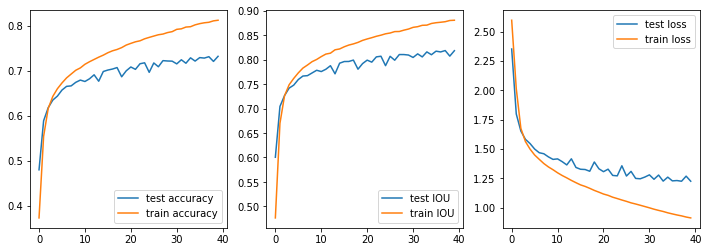

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.807
Test accuracy:0.712
Train IOU:0.877
Test IOU:0.801
Train loss loss:0.937
Test loss loss:1.308


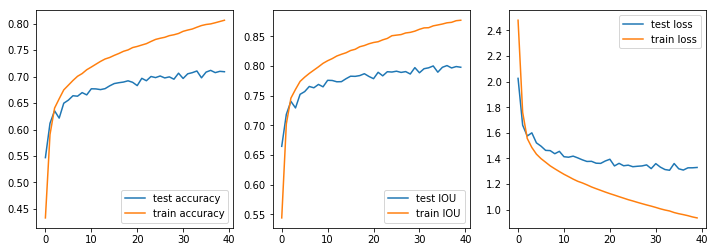

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.838
Test accuracy:0.730
Train IOU:0.901
Test IOU:0.816
Train loss loss:0.813
Test loss loss:1.236


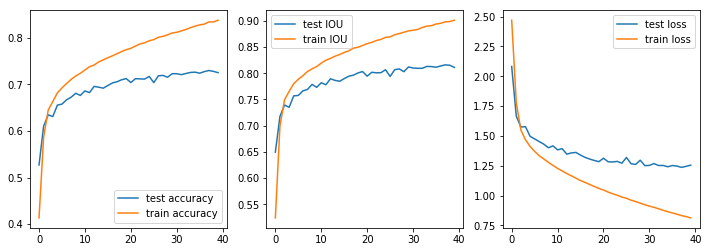

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.860
Test accuracy:0.743
Train IOU:0.915
Test IOU:0.825
Train loss loss:0.729
Test loss loss:1.189


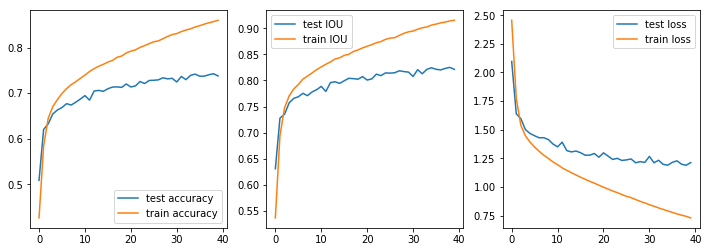

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.823
Test accuracy:0.730
Train IOU:0.889
Test IOU:0.816
Train loss loss:0.866
Test loss loss:1.227


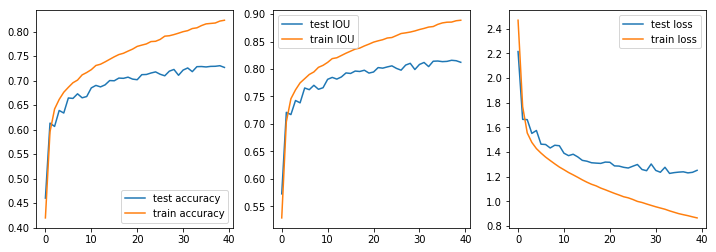

---------------------------------------------------------------------------------------------------- 



In [47]:
f = stats(CDN_tst, CDN_trn, ephocs=40, params=[1,2,3,4,5])

## CDN

In [10]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'RL/EXP/CDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=60)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')



params_dir: ../data/training/models/All/unorder1_RL/EXP/CDN
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.70 ;acc:0.22 ;iou:0.33 ;qMean:0.00 ;qSTD:0.12 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.59 ;iRange:0.13 ;Gq:0.10130 ;Gi:0.18413 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.65 ;acc:0.34 ;iou:0.45 ;qMean:-0.00 ;qSTD:0.12 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:0.10967 ;Gi:0.18578 ;time: 0:00:21
b:100 ;lr:0.050 ;loss:2.62 ;acc:0.41 ;iou:0.48 ;qMean:-0.00 ;qSTD:0.12 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:0.14572 ;Gi:0.20859 ;time: 0:00:42
b:150 ;lr:0.050 ;loss:2.60 ;acc:0.47 ;iou:0.58 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:0.20403 ;Gi:0.22892 ;time: 0:01:04
b:200 ;lr:0.050 ;loss:2.41 ;acc:0.50 ;iou:0.59 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:0.29788 ;Gi:0.2

batch: 50 ;loss: 1.494 ;acc: 0.670 ;iou_acc: 0.730 ;time: 0:02:17
batch: 100 ;loss: 1.490 ;acc: 0.685 ;iou_acc: 0.780 ;time: 0:02:25
batch: 150 ;loss: 1.596 ;acc: 0.675 ;iou_acc: 0.740 ;time: 0:02:34
batch: 200 ;loss: 1.379 ;acc: 0.660 ;iou_acc: 0.770 ;time: 0:02:42
batch: 250 ;loss: 1.521 ;acc: 0.620 ;iou_acc: 0.730 ;time: 0:02:50

*Test loss: 1.450 ;Test accuracy 0.669 ;Test IOU: 0.769 ;Time: 0:02:58
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.19 ;acc:0.73 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.61 ;iRange:0.13 ;Gq:0.99098 ;Gi:0.62388 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.24 ;acc:0.70 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.61 ;iRange:0.13 ;Gq:1.03927 ;Gi:0.65646 ;time: 0:00:22
b:100 ;lr:0.050 ;loss:1.46 ;acc:0.66 ;iou:0.77 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.61 ;iRange:0.13 ;Gq:1.07390 ;Gi:0.61856 ;time: 0:00:42
b:150 ;lr:0.050 ;loss:1.34 ;acc:0.65 ;iou:0.74 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.6

batch: 0 ;loss: 1.186 ;acc: 0.745 ;iou_acc: 0.855 ;time: 0:01:55
batch: 50 ;loss: 1.365 ;acc: 0.705 ;iou_acc: 0.775 ;time: 0:02:03
batch: 100 ;loss: 1.356 ;acc: 0.730 ;iou_acc: 0.810 ;time: 0:02:11
batch: 150 ;loss: 1.524 ;acc: 0.680 ;iou_acc: 0.760 ;time: 0:02:19
batch: 200 ;loss: 1.234 ;acc: 0.690 ;iou_acc: 0.780 ;time: 0:02:27
batch: 250 ;loss: 1.380 ;acc: 0.675 ;iou_acc: 0.765 ;time: 0:02:35

*Test loss: 1.323 ;Test accuracy 0.702 ;Test IOU: 0.795 ;Time: 0:02:42
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:1.15 ;acc:0.79 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.63 ;iRange:0.13 ;Gq:1.09027 ;Gi:0.74331 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.26 ;acc:0.74 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:1.12886 ;Gi:0.70750 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:1.00 ;acc:0.79 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:1.11844 ;Gi:0.71324 ;time: 0:00:40
b:150 ;lr:0.050 ;loss:1.02 ;acc:0.80 ;


*Tr loss: 1.073 ;Tr acc: 0.771 ;IOU acc: 0.849 ;qMean:0.000 ;qSTD:0.137 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.641 ;imgRange:0.129 ;Gq:1.20863 ;Gi:0.90636 ;Time: 0:01:55 

Testing, ephoc: 14
batch: 0 ;loss: 1.120 ;acc: 0.755 ;iou_acc: 0.860 ;time: 0:01:55
batch: 50 ;loss: 1.307 ;acc: 0.700 ;iou_acc: 0.780 ;time: 0:02:03
batch: 100 ;loss: 1.306 ;acc: 0.720 ;iou_acc: 0.795 ;time: 0:02:12
batch: 150 ;loss: 1.470 ;acc: 0.660 ;iou_acc: 0.725 ;time: 0:02:20
batch: 200 ;loss: 1.124 ;acc: 0.735 ;iou_acc: 0.810 ;time: 0:02:28
batch: 250 ;loss: 1.333 ;acc: 0.695 ;iou_acc: 0.780 ;time: 0:02:36

*Test loss: 1.256 ;Test accuracy 0.720 ;Test IOU: 0.809 ;Time: 0:02:43
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:1.02 ;acc:0.81 ;iou:0.86 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.12905 ;Gi:1.01238 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:0.99 ;acc:0.80 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.64 ;iRange:0.13 ;Gq:1.16146 ;Gi:0.84675 ;time: 0:00:19
b:100 ;lr:

b:250 ;lr:0.050 ;loss:0.88 ;acc:0.81 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.11447 ;Gi:1.05730 ;time: 0:01:38

*Tr loss: 0.977 ;Tr acc: 0.797 ;IOU acc: 0.868 ;qMean:0.000 ;qSTD:0.139 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.656 ;imgRange:0.130 ;Gq:1.24740 ;Gi:1.06374 ;Time: 0:01:56 

Testing, ephoc: 19
batch: 0 ;loss: 1.091 ;acc: 0.760 ;iou_acc: 0.855 ;time: 0:01:57
batch: 50 ;loss: 1.310 ;acc: 0.690 ;iou_acc: 0.780 ;time: 0:02:04
batch: 100 ;loss: 1.257 ;acc: 0.735 ;iou_acc: 0.805 ;time: 0:02:12
batch: 150 ;loss: 1.478 ;acc: 0.665 ;iou_acc: 0.725 ;time: 0:02:20
batch: 200 ;loss: 1.114 ;acc: 0.735 ;iou_acc: 0.825 ;time: 0:02:28
batch: 250 ;loss: 1.281 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:02:37

*Test loss: 1.228 ;Test accuracy 0.726 ;Test IOU: 0.812 ;Time: 0:02:44
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:0.76 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.10689 ;Gi:0.94443 ;time: 0:00:01
b:50 ;lr:0

b:200 ;lr:0.050 ;loss:0.95 ;acc:0.79 ;iou:0.82 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.25992 ;Gi:1.15244 ;time: 0:01:16
b:250 ;lr:0.050 ;loss:0.77 ;acc:0.84 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.17098 ;Gi:1.16740 ;time: 0:01:35

*Tr loss: 0.882 ;Tr acc: 0.821 ;IOU acc: 0.886 ;qMean:0.000 ;qSTD:0.143 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.676 ;imgRange:0.130 ;Gq:1.27619 ;Gi:1.21301 ;Time: 0:01:53 

Testing, ephoc: 24
batch: 0 ;loss: 1.039 ;acc: 0.810 ;iou_acc: 0.870 ;time: 0:01:53
batch: 50 ;loss: 1.348 ;acc: 0.695 ;iou_acc: 0.795 ;time: 0:02:01
batch: 100 ;loss: 1.171 ;acc: 0.745 ;iou_acc: 0.820 ;time: 0:02:08
batch: 150 ;loss: 1.441 ;acc: 0.695 ;iou_acc: 0.775 ;time: 0:02:16
batch: 200 ;loss: 1.038 ;acc: 0.775 ;iou_acc: 0.845 ;time: 0:02:23
batch: 250 ;loss: 1.283 ;acc: 0.710 ;iou_acc: 0.795 ;time: 0:02:31

*Test loss: 1.198 ;Test accuracy 0.738 ;Test IOU: 0.820 ;Time: 0:02:38
Train, ephoc: 25
b:0 ;lr:

b:150 ;lr:0.050 ;loss:0.76 ;acc:0.87 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.33364 ;Gi:1.37109 ;time: 0:00:58
b:200 ;lr:0.050 ;loss:0.78 ;acc:0.81 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.27875 ;Gi:1.42478 ;time: 0:01:17
b:250 ;lr:0.050 ;loss:0.81 ;acc:0.84 ;iou:0.89 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.70 ;iRange:0.13 ;Gq:1.31949 ;Gi:1.23878 ;time: 0:01:37

*Tr loss: 0.798 ;Tr acc: 0.842 ;IOU acc: 0.901 ;qMean:0.000 ;qSTD:0.146 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.691 ;imgRange:0.130 ;Gq:1.29462 ;Gi:1.34272 ;Time: 0:01:53 

Testing, ephoc: 29
batch: 0 ;loss: 0.928 ;acc: 0.815 ;iou_acc: 0.875 ;time: 0:01:53
batch: 50 ;loss: 1.247 ;acc: 0.710 ;iou_acc: 0.810 ;time: 0:02:01
batch: 100 ;loss: 1.139 ;acc: 0.785 ;iou_acc: 0.850 ;time: 0:02:08
batch: 150 ;loss: 1.447 ;acc: 0.695 ;iou_acc: 0.765 ;time: 0:02:16
batch: 200 ;loss: 1.033 ;acc: 0.765 ;iou_acc: 0.845 ;time: 0:02:24
batch:

b:100 ;lr:0.045 ;loss:0.67 ;acc:0.86 ;iou:0.93 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.70 ;iRange:0.13 ;Gq:1.24964 ;Gi:1.46994 ;time: 0:00:39
b:150 ;lr:0.045 ;loss:0.64 ;acc:0.89 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.13539 ;Gi:1.24170 ;time: 0:00:58
b:200 ;lr:0.045 ;loss:0.68 ;acc:0.88 ;iou:0.92 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.25027 ;Gi:1.33827 ;time: 0:01:17
b:250 ;lr:0.045 ;loss:0.69 ;acc:0.88 ;iou:0.93 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.33558 ;Gi:1.42447 ;time: 0:01:37

*Tr loss: 0.724 ;Tr acc: 0.860 ;IOU acc: 0.914 ;qMean:0.000 ;qSTD:0.148 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.702 ;imgRange:0.130 ;Gq:1.29459 ;Gi:1.43968 ;Time: 0:01:56 

Testing, ephoc: 34
batch: 0 ;loss: 0.898 ;acc: 0.815 ;iou_acc: 0.900 ;time: 0:01:56
batch: 50 ;loss: 1.236 ;acc: 0.700 ;iou_acc: 0.810 ;time: 0:02:05
batch: 100 ;loss: 1.085 ;acc: 0.760 ;iou_acc: 0.8

b:50 ;lr:0.045 ;loss:0.62 ;acc:0.89 ;iou:0.95 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.28095 ;Gi:1.39909 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.59 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.21056 ;Gi:1.50122 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.69 ;acc:0.87 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.41076 ;Gi:1.69926 ;time: 0:00:56
b:200 ;lr:0.045 ;loss:0.60 ;acc:0.89 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.31567 ;Gi:1.52927 ;time: 0:01:15
b:250 ;lr:0.045 ;loss:0.66 ;acc:0.89 ;iou:0.92 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.24908 ;Gi:1.67471 ;time: 0:01:33

*Tr loss: 0.664 ;Tr acc: 0.875 ;IOU acc: 0.924 ;qMean:0.000 ;qSTD:0.150 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.717 ;imgRange:0.130 ;Gq:1.30692 ;Gi:1.51814 ;Time: 0:01:51 

Testing, ephoc: 39
batch: 0 ;loss: 0.955 ;

b:0 ;lr:0.045 ;loss:0.56 ;acc:0.88 ;iou:0.95 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.26585 ;Gi:1.63881 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.60 ;acc:0.90 ;iou:0.93 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.21465 ;Gi:1.53582 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.58 ;acc:0.90 ;iou:0.93 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.22795 ;Gi:1.44820 ;time: 0:00:36
b:150 ;lr:0.045 ;loss:0.53 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.22531 ;Gi:1.56233 ;time: 0:00:55
b:200 ;lr:0.045 ;loss:0.60 ;acc:0.89 ;iou:0.92 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.38283 ;Gi:1.59861 ;time: 0:01:15
b:250 ;lr:0.045 ;loss:0.57 ;acc:0.91 ;iou:0.95 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.27001 ;Gi:1.49258 ;time: 0:01:34

*Tr loss: 0.610 ;Tr acc: 0.888 ;IOU acc: 0.932 ;qMean:


*Test loss: 1.135 ;Test accuracy 0.764 ;Test IOU: 0.841 ;Time: 0:02:39
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.49 ;acc:0.93 ;iou:0.96 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.07413 ;Gi:1.37745 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.58 ;acc:0.90 ;iou:0.95 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.37871 ;Gi:1.74758 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:0.57 ;acc:0.89 ;iou:0.94 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.30688 ;Gi:1.69700 ;time: 0:00:40
b:150 ;lr:0.045 ;loss:0.54 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.40892 ;Gi:1.80340 ;time: 0:00:59
b:200 ;lr:0.045 ;loss:0.62 ;acc:0.89 ;iou:0.94 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.41594 ;Gi:1.67282 ;time: 0:01:18
b:250 ;lr:0.045 ;loss:0.54 ;acc:0.91 ;iou:0.95 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1

batch: 200 ;loss: 1.067 ;acc: 0.795 ;iou_acc: 0.860 ;time: 0:02:25
batch: 250 ;loss: 1.131 ;acc: 0.765 ;iou_acc: 0.860 ;time: 0:02:33

*Test loss: 1.143 ;Test accuracy 0.766 ;Test IOU: 0.843 ;Time: 0:02:40
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.52 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.33929 ;Gi:1.90630 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.55 ;acc:0.89 ;iou:0.93 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.36898 ;Gi:1.68126 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.41 ;acc:0.95 ;iou:0.95 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.11651 ;Gi:1.41657 ;time: 0:00:39
b:150 ;lr:0.045 ;loss:0.47 ;acc:0.92 ;iou:0.95 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.34850 ;Gi:1.78780 ;time: 0:00:57
b:200 ;lr:0.045 ;loss:0.49 ;acc:0.93 ;iou:0.97 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.18166 ;Gi:1.52044 ;time

batch: 100 ;loss: 1.075 ;acc: 0.785 ;iou_acc: 0.870 ;time: 0:02:09
batch: 150 ;loss: 1.485 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:02:18
batch: 200 ;loss: 1.066 ;acc: 0.800 ;iou_acc: 0.870 ;time: 0:02:25
batch: 250 ;loss: 1.215 ;acc: 0.740 ;iou_acc: 0.845 ;time: 0:02:33

*Test loss: 1.165 ;Test accuracy 0.766 ;Test IOU: 0.843 ;Time: 0:02:40
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.44 ;acc:0.94 ;iou:0.95 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.19875 ;Gi:1.55766 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.44 ;acc:0.93 ;iou:0.97 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.26424 ;Gi:1.68722 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:0.54 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.29776 ;Gi:1.71449 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.49 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.24519 ;Gi:1.69735 ;time: 0:00:57
b:200 ;lr:0.04

In [11]:
np.save(open('../data/training/results/CDN_tst.bin', 'wb'), tst)
np.save(open('../data/training/results/CDN_trn.bin', 'wb'), trn)
np.save(open('../data/training/results/CDN_imgMean.bin', 'wb'), imgMean_list)
np.save(open('../data/training/results/CDN_imgSTD.bin', 'wb'), imgSTD_list)
np.save(open('../data/training/results/CDN_imgRange.bin', 'wb'), imgRange_list)
np.save(open('../data/training/results/CDN_qMean.bin', 'wb'), qMean_list)
np.save(open('../data/training/results/CDN_qSTD.bin', 'wb'), qSTD_list)
np.save(open('../data/training/results/CDN_qRange.bin', 'wb'), qRange_list)
np.save(open('../data/training/results/CDN_Gq.bin', 'wb'), Gq)
np.save(open('../data/training/results/CDN_Gimg.bin', 'wb'), Gimg)

Train accuracy:0.920
Test accuracy:0.770
Train P@1:0.954
Test P@1:0.846
Train loss loss:0.475
Test loss loss:1.113


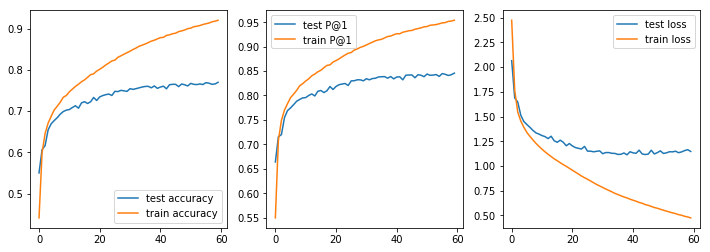

---------------------------------------------------------------------------------------------------- 



In [33]:
f = stats([tst], [trn], ephocs=60, params=[200])

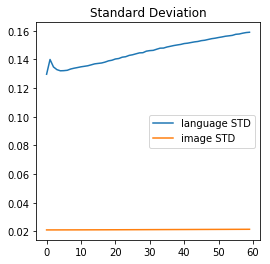

In [15]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
ephocs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

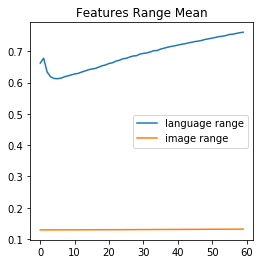

In [18]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
ephocs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:60])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

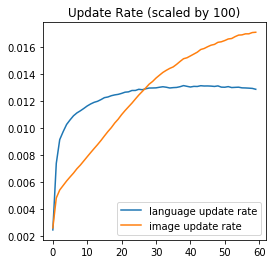

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
ephocs=60

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## CDN + dropout

In [19]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'RL/EXP/CDNdrop'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=100, dropout_in=0.5, dropout_out=0.5)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/CDNdrop
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.71 ;acc:0.23 ;iou:0.30 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:0.09414 ;Gi:0.17953 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.71 ;acc:0.24 ;iou:0.34 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:0.09824 ;Gi:0.17510 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:2.68 ;acc:0.35 ;iou:0.47 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:0.11422 ;Gi:0.18636 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:2.66 ;acc:0.39 ;iou:0.51 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:0.14603 ;Gi:0.19722 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:2.58 ;acc:0.42 ;iou:0.47 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:0.20891 ;Gi

batch: 50 ;loss: 1.555 ;acc: 0.635 ;iou_acc: 0.695 ;time: 0:01:58
batch: 100 ;loss: 1.571 ;acc: 0.655 ;iou_acc: 0.750 ;time: 0:02:05
batch: 150 ;loss: 1.654 ;acc: 0.640 ;iou_acc: 0.720 ;time: 0:02:12
batch: 200 ;loss: 1.434 ;acc: 0.645 ;iou_acc: 0.740 ;time: 0:02:20
batch: 250 ;loss: 1.603 ;acc: 0.605 ;iou_acc: 0.725 ;time: 0:02:27

*Test loss: 1.508 ;Test accuracy 0.656 ;Test IOU: 0.758 ;Time: 0:02:35
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.46 ;acc:0.69 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.09048 ;Gi:0.65660 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.46 ;acc:0.68 ;iou:0.76 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:0.99312 ;Gi:0.56878 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.40 ;acc:0.70 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.15822 ;Gi:0.64391 ;time: 0:00:36
b:150 ;lr:0.050 ;loss:1.40 ;acc:0.69 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.

batch: 0 ;loss: 1.280 ;acc: 0.720 ;iou_acc: 0.830 ;time: 0:01:48
batch: 50 ;loss: 1.453 ;acc: 0.670 ;iou_acc: 0.730 ;time: 0:01:55
batch: 100 ;loss: 1.443 ;acc: 0.695 ;iou_acc: 0.755 ;time: 0:02:02
batch: 150 ;loss: 1.557 ;acc: 0.650 ;iou_acc: 0.725 ;time: 0:02:10
batch: 200 ;loss: 1.262 ;acc: 0.690 ;iou_acc: 0.795 ;time: 0:02:17
batch: 250 ;loss: 1.495 ;acc: 0.630 ;iou_acc: 0.745 ;time: 0:02:24

*Test loss: 1.385 ;Test accuracy 0.685 ;Test IOU: 0.782 ;Time: 0:02:32
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:1.34 ;acc:0.69 ;iou:0.77 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.21230 ;Gi:0.82212 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.44 ;acc:0.69 ;iou:0.74 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.31788 ;Gi:0.78544 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:1.08 ;acc:0.76 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.01298 ;Gi:0.68626 ;time: 0:00:37
b:150 ;lr:0.050 ;loss:1.35 ;acc:0.70 ;


*Tr loss: 1.198 ;Tr acc: 0.737 ;IOU acc: 0.823 ;qMean:-0.000 ;qSTD:0.129 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.650 ;imgRange:0.129 ;Gq:1.24373 ;Gi:0.90909 ;Time: 0:01:49 

Testing, ephoc: 14
batch: 0 ;loss: 1.187 ;acc: 0.745 ;iou_acc: 0.850 ;time: 0:01:50
batch: 50 ;loss: 1.366 ;acc: 0.700 ;iou_acc: 0.740 ;time: 0:01:57
batch: 100 ;loss: 1.371 ;acc: 0.705 ;iou_acc: 0.795 ;time: 0:02:04
batch: 150 ;loss: 1.518 ;acc: 0.650 ;iou_acc: 0.735 ;time: 0:02:11
batch: 200 ;loss: 1.176 ;acc: 0.710 ;iou_acc: 0.800 ;time: 0:02:19
batch: 250 ;loss: 1.385 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:02:26

*Test loss: 1.301 ;Test accuracy 0.707 ;Test IOU: 0.799 ;Time: 0:02:33
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:1.19 ;acc:0.75 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.64 ;iRange:0.13 ;Gq:1.21782 ;Gi:0.93689 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.06 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.27153 ;Gi:1.01883 ;time: 0:00:19
b:100 ;l

b:250 ;lr:0.050 ;loss:1.08 ;acc:0.78 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.24554 ;Gi:1.08184 ;time: 0:01:30

*Tr loss: 1.115 ;Tr acc: 0.760 ;IOU acc: 0.841 ;qMean:-0.000 ;qSTD:0.130 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.651 ;imgRange:0.129 ;Gq:1.28548 ;Gi:1.08987 ;Time: 0:01:47 

Testing, ephoc: 19
batch: 0 ;loss: 1.130 ;acc: 0.750 ;iou_acc: 0.840 ;time: 0:01:47
batch: 50 ;loss: 1.329 ;acc: 0.695 ;iou_acc: 0.760 ;time: 0:01:54
batch: 100 ;loss: 1.300 ;acc: 0.715 ;iou_acc: 0.800 ;time: 0:02:01
batch: 150 ;loss: 1.424 ;acc: 0.670 ;iou_acc: 0.750 ;time: 0:02:09
batch: 200 ;loss: 1.130 ;acc: 0.740 ;iou_acc: 0.825 ;time: 0:02:16
batch: 250 ;loss: 1.341 ;acc: 0.680 ;iou_acc: 0.775 ;time: 0:02:24

*Test loss: 1.246 ;Test accuracy 0.721 ;Test IOU: 0.811 ;Time: 0:02:31
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:1.08 ;acc:0.75 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.22792 ;Gi:1.03539 ;time: 0:00:00
b:50 ;l

b:200 ;lr:0.050 ;loss:1.23 ;acc:0.74 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.43797 ;Gi:1.38186 ;time: 0:01:14
b:250 ;lr:0.050 ;loss:1.11 ;acc:0.74 ;iou:0.83 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.41839 ;Gi:1.39231 ;time: 0:01:31

*Tr loss: 1.046 ;Tr acc: 0.777 ;IOU acc: 0.854 ;qMean:-0.000 ;qSTD:0.131 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.654 ;imgRange:0.130 ;Gq:1.31992 ;Gi:1.26960 ;Time: 0:01:47 

Testing, ephoc: 24
batch: 0 ;loss: 1.072 ;acc: 0.765 ;iou_acc: 0.845 ;time: 0:01:47
batch: 50 ;loss: 1.288 ;acc: 0.710 ;iou_acc: 0.775 ;time: 0:01:55
batch: 100 ;loss: 1.262 ;acc: 0.725 ;iou_acc: 0.810 ;time: 0:02:02
batch: 150 ;loss: 1.404 ;acc: 0.700 ;iou_acc: 0.770 ;time: 0:02:10
batch: 200 ;loss: 1.089 ;acc: 0.750 ;iou_acc: 0.835 ;time: 0:02:17
batch: 250 ;loss: 1.305 ;acc: 0.675 ;iou_acc: 0.785 ;time: 0:02:25

*Test loss: 1.206 ;Test accuracy 0.730 ;Test IOU: 0.816 ;Time: 0:02:32
Train, ephoc: 25
b:0 ;l

b:150 ;lr:0.050 ;loss:0.94 ;acc:0.79 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.46849 ;Gi:1.60998 ;time: 0:00:55
b:200 ;lr:0.050 ;loss:0.98 ;acc:0.80 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.36936 ;Gi:1.36100 ;time: 0:01:13
b:250 ;lr:0.050 ;loss:1.14 ;acc:0.76 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.41181 ;Gi:1.43141 ;time: 0:01:33

*Tr loss: 0.985 ;Tr acc: 0.791 ;IOU acc: 0.864 ;qMean:-0.000 ;qSTD:0.132 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.653 ;imgRange:0.130 ;Gq:1.35382 ;Gi:1.44473 ;Time: 0:01:50 

Testing, ephoc: 29
batch: 0 ;loss: 1.019 ;acc: 0.805 ;iou_acc: 0.850 ;time: 0:01:50
batch: 50 ;loss: 1.301 ;acc: 0.710 ;iou_acc: 0.780 ;time: 0:01:57
batch: 100 ;loss: 1.199 ;acc: 0.755 ;iou_acc: 0.830 ;time: 0:02:05
batch: 150 ;loss: 1.399 ;acc: 0.685 ;iou_acc: 0.760 ;time: 0:02:13
batch: 200 ;loss: 1.075 ;acc: 0.765 ;iou_acc: 0.850 ;time: 0:02:20
ba

b:100 ;lr:0.045 ;loss:1.06 ;acc:0.77 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.50050 ;Gi:1.88869 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.92 ;acc:0.82 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.33311 ;Gi:1.40879 ;time: 0:00:55
b:200 ;lr:0.045 ;loss:0.98 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.36793 ;Gi:1.53305 ;time: 0:01:14
b:250 ;lr:0.045 ;loss:0.78 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.15910 ;Gi:1.40621 ;time: 0:01:33

*Tr loss: 0.929 ;Tr acc: 0.807 ;IOU acc: 0.875 ;qMean:-0.000 ;qSTD:0.133 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.657 ;imgRange:0.130 ;Gq:1.37831 ;Gi:1.60353 ;Time: 0:01:50 

Testing, ephoc: 34
batch: 0 ;loss: 0.973 ;acc: 0.770 ;iou_acc: 0.815 ;time: 0:01:51
batch: 50 ;loss: 1.268 ;acc: 0.715 ;iou_acc: 0.795 ;time: 0:01:58
batch: 100 ;loss: 1.158 ;acc: 0.765 ;iou_acc:

b:50 ;lr:0.045 ;loss:0.80 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.23470 ;Gi:1.63839 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:0.99 ;acc:0.81 ;iou:0.87 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.52831 ;Gi:1.73410 ;time: 0:00:39
b:150 ;lr:0.045 ;loss:1.04 ;acc:0.77 ;iou:0.88 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.41920 ;Gi:1.73465 ;time: 0:00:58
b:200 ;lr:0.045 ;loss:0.81 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.16859 ;Gi:1.39711 ;time: 0:01:17
b:250 ;lr:0.045 ;loss:0.86 ;acc:0.80 ;iou:0.89 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.47216 ;Gi:1.92640 ;time: 0:01:36

*Tr loss: 0.881 ;Tr acc: 0.817 ;IOU acc: 0.883 ;qMean:0.000 ;qSTD:0.134 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.660 ;imgRange:0.130 ;Gq:1.39800 ;Gi:1.73164 ;Time: 0:01:53 

Testing, ephoc: 39
batch: 0 ;loss: 0.953 

b:0 ;lr:0.045 ;loss:0.77 ;acc:0.85 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.42021 ;Gi:1.86268 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.89 ;acc:0.81 ;iou:0.85 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.47724 ;Gi:1.82252 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.82 ;acc:0.84 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.35493 ;Gi:1.71572 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.84 ;acc:0.83 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.51485 ;Gi:2.13317 ;time: 0:00:56
b:200 ;lr:0.045 ;loss:0.76 ;acc:0.85 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.21095 ;Gi:1.50849 ;time: 0:01:14
b:250 ;lr:0.045 ;loss:0.79 ;acc:0.84 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.30925 ;Gi:1.93527 ;time: 0:01:33

*Tr loss: 0.838 ;Tr acc: 0.828 ;IOU acc: 0.890 ;qMean:


*Test loss: 1.113 ;Test accuracy 0.752 ;Test IOU: 0.832 ;Time: 0:02:32
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.64 ;acc:0.88 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.31137 ;Gi:1.73056 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.74 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.45277 ;Gi:2.16071 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.85 ;acc:0.82 ;iou:0.86 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.40878 ;Gi:1.91554 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.83 ;acc:0.84 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.45916 ;Gi:2.09376 ;time: 0:00:56
b:200 ;lr:0.045 ;loss:0.95 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.66149 ;Gi:2.24107 ;time: 0:01:14
b:250 ;lr:0.045 ;loss:0.80 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1

batch: 200 ;loss: 0.971 ;acc: 0.760 ;iou_acc: 0.850 ;time: 0:02:18
batch: 250 ;loss: 1.181 ;acc: 0.725 ;iou_acc: 0.825 ;time: 0:02:26

*Test loss: 1.078 ;Test accuracy 0.762 ;Test IOU: 0.841 ;Time: 0:02:33
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.76 ;acc:0.83 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.66543 ;Gi:2.23910 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.79 ;acc:0.84 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.41560 ;Gi:2.03792 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.69 ;acc:0.86 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.46356 ;Gi:2.04807 ;time: 0:00:36
b:150 ;lr:0.045 ;loss:0.84 ;acc:0.85 ;iou:0.93 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.43337 ;Gi:1.97074 ;time: 0:00:54
b:200 ;lr:0.045 ;loss:0.81 ;acc:0.86 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.49883 ;Gi:2.02079 ;time

batch: 100 ;loss: 1.074 ;acc: 0.785 ;iou_acc: 0.850 ;time: 0:02:05
batch: 150 ;loss: 1.304 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:02:13
batch: 200 ;loss: 0.979 ;acc: 0.775 ;iou_acc: 0.865 ;time: 0:02:20
batch: 250 ;loss: 1.171 ;acc: 0.740 ;iou_acc: 0.835 ;time: 0:02:28

*Test loss: 1.075 ;Test accuracy 0.762 ;Test IOU: 0.840 ;Time: 0:02:35
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.87 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.48285 ;Gi:2.17955 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.71 ;acc:0.86 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.40131 ;Gi:1.90318 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.80 ;acc:0.83 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.36751 ;Gi:2.26582 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.61 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.31864 ;Gi:2.10285 ;time: 0:00:55
b:200 ;lr:0.04

batch: 0 ;loss: 0.872 ;acc: 0.820 ;iou_acc: 0.870 ;time: 0:01:51
batch: 50 ;loss: 1.228 ;acc: 0.740 ;iou_acc: 0.840 ;time: 0:01:58
batch: 100 ;loss: 1.049 ;acc: 0.770 ;iou_acc: 0.835 ;time: 0:02:06
batch: 150 ;loss: 1.303 ;acc: 0.740 ;iou_acc: 0.820 ;time: 0:02:13
batch: 200 ;loss: 0.973 ;acc: 0.770 ;iou_acc: 0.860 ;time: 0:02:21
batch: 250 ;loss: 1.181 ;acc: 0.720 ;iou_acc: 0.815 ;time: 0:02:28

*Test loss: 1.068 ;Test accuracy 0.766 ;Test IOU: 0.843 ;Time: 0:02:36
Train, ephoc: 64
b:0 ;lr:0.045 ;loss:0.72 ;acc:0.87 ;iou:0.93 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.36852 ;Gi:2.17920 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.71 ;acc:0.87 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.46977 ;Gi:2.25608 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.73 ;acc:0.84 ;iou:0.90 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.52689 ;Gi:2.36494 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.56 ;acc:0.89 ;iou

batch: 0 ;loss: 0.854 ;acc: 0.820 ;iou_acc: 0.870 ;time: 0:01:52
batch: 50 ;loss: 1.196 ;acc: 0.765 ;iou_acc: 0.840 ;time: 0:01:59
batch: 100 ;loss: 1.065 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:02:07
batch: 150 ;loss: 1.308 ;acc: 0.710 ;iou_acc: 0.790 ;time: 0:02:15
batch: 200 ;loss: 0.963 ;acc: 0.770 ;iou_acc: 0.845 ;time: 0:02:22
batch: 250 ;loss: 1.141 ;acc: 0.740 ;iou_acc: 0.845 ;time: 0:02:30

*Test loss: 1.059 ;Test accuracy 0.767 ;Test IOU: 0.844 ;Time: 0:02:37
Train, ephoc: 69
b:0 ;lr:0.040 ;loss:0.74 ;acc:0.84 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.56397 ;Gi:2.19020 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.72 ;acc:0.85 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.45566 ;Gi:2.02832 ;time: 0:00:18
b:100 ;lr:0.040 ;loss:0.71 ;acc:0.85 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.46477 ;Gi:2.17426 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.75 ;acc:0.86 ;iou

batch: 0 ;loss: 0.833 ;acc: 0.835 ;iou_acc: 0.865 ;time: 0:01:49
batch: 50 ;loss: 1.231 ;acc: 0.725 ;iou_acc: 0.815 ;time: 0:01:56
batch: 100 ;loss: 1.048 ;acc: 0.760 ;iou_acc: 0.825 ;time: 0:02:04
batch: 150 ;loss: 1.327 ;acc: 0.735 ;iou_acc: 0.810 ;time: 0:02:11
batch: 200 ;loss: 0.992 ;acc: 0.770 ;iou_acc: 0.850 ;time: 0:02:19
batch: 250 ;loss: 1.156 ;acc: 0.720 ;iou_acc: 0.830 ;time: 0:02:26

*Test loss: 1.057 ;Test accuracy 0.769 ;Test IOU: 0.846 ;Time: 0:02:32
Train, ephoc: 74
b:0 ;lr:0.040 ;loss:0.49 ;acc:0.92 ;iou:0.96 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.66 ;iRange:0.13 ;Gq:1.31629 ;Gi:1.96615 ;time: 0:00:01
b:50 ;lr:0.040 ;loss:0.72 ;acc:0.84 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.38779 ;Gi:2.06404 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.69 ;acc:0.83 ;iou:0.89 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.55970 ;Gi:2.20876 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.70 ;acc:0.86 ;iou

batch: 0 ;loss: 0.807 ;acc: 0.845 ;iou_acc: 0.895 ;time: 0:01:50
batch: 50 ;loss: 1.222 ;acc: 0.730 ;iou_acc: 0.825 ;time: 0:01:57
batch: 100 ;loss: 1.030 ;acc: 0.785 ;iou_acc: 0.850 ;time: 0:02:04
batch: 150 ;loss: 1.249 ;acc: 0.740 ;iou_acc: 0.815 ;time: 0:02:11
batch: 200 ;loss: 0.937 ;acc: 0.780 ;iou_acc: 0.870 ;time: 0:02:19
batch: 250 ;loss: 1.124 ;acc: 0.750 ;iou_acc: 0.845 ;time: 0:02:26

*Test loss: 1.042 ;Test accuracy 0.775 ;Test IOU: 0.850 ;Time: 0:02:33
Train, ephoc: 79
b:0 ;lr:0.040 ;loss:0.56 ;acc:0.89 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.49090 ;Gi:2.20161 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.54 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.34255 ;Gi:2.12211 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.72 ;acc:0.85 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.65471 ;Gi:2.60799 ;time: 0:00:38
b:150 ;lr:0.040 ;loss:0.81 ;acc:0.84 ;iou

batch: 0 ;loss: 0.814 ;acc: 0.830 ;iou_acc: 0.875 ;time: 0:01:48
batch: 50 ;loss: 1.248 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:01:55
batch: 100 ;loss: 1.060 ;acc: 0.785 ;iou_acc: 0.855 ;time: 0:02:03
batch: 150 ;loss: 1.294 ;acc: 0.735 ;iou_acc: 0.810 ;time: 0:02:10
batch: 200 ;loss: 0.964 ;acc: 0.780 ;iou_acc: 0.860 ;time: 0:02:18
batch: 250 ;loss: 1.132 ;acc: 0.735 ;iou_acc: 0.825 ;time: 0:02:25

*Test loss: 1.054 ;Test accuracy 0.774 ;Test IOU: 0.849 ;Time: 0:02:32
Train, ephoc: 84
b:0 ;lr:0.040 ;loss:0.61 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.38402 ;Gi:2.25025 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.66 ;acc:0.87 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.71397 ;Gi:2.78864 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.55 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.51587 ;Gi:2.59331 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.52 ;acc:0.92 ;iou

batch: 0 ;loss: 0.822 ;acc: 0.840 ;iou_acc: 0.885 ;time: 0:01:49
batch: 50 ;loss: 1.224 ;acc: 0.750 ;iou_acc: 0.835 ;time: 0:01:56
batch: 100 ;loss: 1.055 ;acc: 0.770 ;iou_acc: 0.840 ;time: 0:02:03
batch: 150 ;loss: 1.288 ;acc: 0.740 ;iou_acc: 0.815 ;time: 0:02:11
batch: 200 ;loss: 0.959 ;acc: 0.770 ;iou_acc: 0.865 ;time: 0:02:18
batch: 250 ;loss: 1.123 ;acc: 0.740 ;iou_acc: 0.835 ;time: 0:02:25

*Test loss: 1.039 ;Test accuracy 0.777 ;Test IOU: 0.852 ;Time: 0:02:32
Train, ephoc: 89
b:0 ;lr:0.040 ;loss:0.57 ;acc:0.90 ;iou:0.95 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.49041 ;Gi:2.60961 ;time: 0:00:01
b:50 ;lr:0.040 ;loss:0.53 ;acc:0.91 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.43211 ;Gi:2.12174 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.61 ;acc:0.90 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.42646 ;Gi:2.33701 ;time: 0:00:38
b:150 ;lr:0.040 ;loss:0.53 ;acc:0.89 ;iou

batch: 0 ;loss: 0.845 ;acc: 0.820 ;iou_acc: 0.870 ;time: 0:01:47
batch: 50 ;loss: 1.226 ;acc: 0.735 ;iou_acc: 0.815 ;time: 0:01:54
batch: 100 ;loss: 1.019 ;acc: 0.780 ;iou_acc: 0.850 ;time: 0:02:02
batch: 150 ;loss: 1.332 ;acc: 0.725 ;iou_acc: 0.810 ;time: 0:02:10
batch: 200 ;loss: 0.976 ;acc: 0.765 ;iou_acc: 0.860 ;time: 0:02:17
batch: 250 ;loss: 1.113 ;acc: 0.745 ;iou_acc: 0.840 ;time: 0:02:25

*Test loss: 1.044 ;Test accuracy 0.775 ;Test IOU: 0.851 ;Time: 0:02:31
Train, ephoc: 94
b:0 ;lr:0.040 ;loss:0.63 ;acc:0.88 ;iou:0.92 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.49433 ;Gi:2.67544 ;time: 0:00:01
b:50 ;lr:0.040 ;loss:0.48 ;acc:0.92 ;iou:0.95 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.16137 ;Gi:1.87712 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.58 ;acc:0.87 ;iou:0.91 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.51708 ;Gi:2.62952 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.62 ;acc:0.88 ;iou

batch: 0 ;loss: 0.806 ;acc: 0.830 ;iou_acc: 0.880 ;time: 0:01:49
batch: 50 ;loss: 1.255 ;acc: 0.725 ;iou_acc: 0.825 ;time: 0:01:56
batch: 100 ;loss: 1.019 ;acc: 0.800 ;iou_acc: 0.875 ;time: 0:02:03
batch: 150 ;loss: 1.318 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:02:11
batch: 200 ;loss: 0.956 ;acc: 0.780 ;iou_acc: 0.865 ;time: 0:02:18
batch: 250 ;loss: 1.141 ;acc: 0.755 ;iou_acc: 0.840 ;time: 0:02:26

*Test loss: 1.046 ;Test accuracy 0.778 ;Test IOU: 0.853 ;Time: 0:02:33
Train, ephoc: 99
b:0 ;lr:0.040 ;loss:0.51 ;acc:0.89 ;iou:0.95 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.41647 ;Gi:2.63659 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.60 ;acc:0.87 ;iou:0.93 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.61413 ;Gi:2.97627 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.59 ;acc:0.88 ;iou:0.94 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.74937 ;Gi:3.22250 ;time: 0:00:38
b:150 ;lr:0.040 ;loss:0.54 ;acc:0.89 ;iou

In [20]:
np.save(open('../data/training/results/CDND_tst.bin', 'wb'), tst)
np.save(open('../data/training/results/CDND_trn.bin', 'wb'), trn)
np.save(open('../data/training/results/CDND_imgMean.bin', 'wb'), imgMean_list)
np.save(open('../data/training/results/CDND_imgSTD.bin', 'wb'), imgSTD_list)
np.save(open('../data/training/results/CDND_imgRange.bin', 'wb'), imgRange_list)
np.save(open('../data/training/results/CDND_qMean.bin', 'wb'), qMean_list)
np.save(open('../data/training/results/CDND_qSTD.bin', 'wb'), qSTD_list)
np.save(open('../data/training/results/CDND_qRange.bin', 'wb'), qRange_list)
np.save(open('../data/training/results/CDND_Gq.bin', 'wb'), Gq)
np.save(open('../data/training/results/CDND_Gimg.bin', 'wb'), Gimg)

Train accuracy:0.905
Test accuracy:0.779
Train IOU:0.942
Test IOU:0.853
Train loss loss:0.524
Test loss loss:1.038


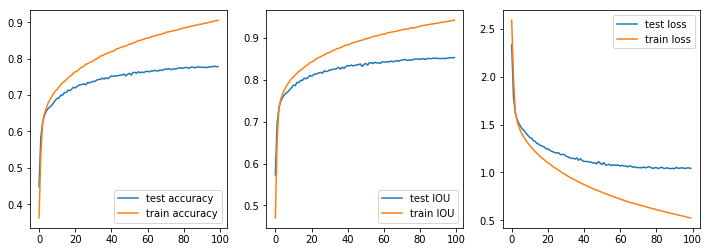

---------------------------------------------------------------------------------------------------- 



In [21]:
f = stats([tst], [trn], ephocs=100, params=[200])

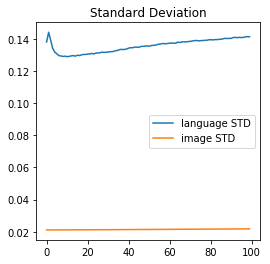

In [22]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

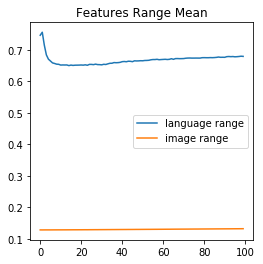

In [24]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange_list, imgRange_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

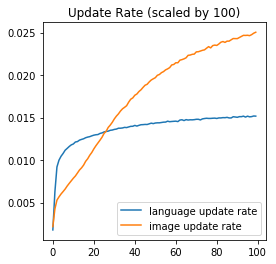

In [25]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## BiCDND

Bidirectional RNN + CDN + Dropout

In [9]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'RL/EXP/BiCDNdrop'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useBidirectionalRnn=True,
    Qscale=0.16,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=100, dropout_in=0.5, dropout_out=0.5)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/BiCDNdrop
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.73 ;acc:0.21 ;iou:0.31 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.79 ;iRange:0.13 ;Gq:0.10878 ;Gi:0.18290 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.67 ;acc:0.23 ;iou:0.29 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.80 ;iRange:0.13 ;Gq:0.11361 ;Gi:0.19109 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:2.66 ;acc:0.31 ;iou:0.41 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.79 ;iRange:0.13 ;Gq:0.13114 ;Gi:0.19921 ;time: 0:00:40
b:150 ;lr:0.050 ;loss:2.57 ;acc:0.46 ;iou:0.55 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.80 ;iRange:0.13 ;Gq:0.16183 ;Gi:0.21736 ;time: 0:01:01
b:200 ;lr:0.050 ;loss:2.53 ;acc:0.48 ;iou:0.56 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.81 ;iRange:0.13 ;Gq:0.22253 ;G

batch: 50 ;loss: 1.477 ;acc: 0.650 ;iou_acc: 0.720 ;time: 0:02:03
batch: 100 ;loss: 1.513 ;acc: 0.700 ;iou_acc: 0.775 ;time: 0:02:12
batch: 150 ;loss: 1.608 ;acc: 0.625 ;iou_acc: 0.710 ;time: 0:02:20
batch: 200 ;loss: 1.408 ;acc: 0.665 ;iou_acc: 0.745 ;time: 0:02:29
batch: 250 ;loss: 1.547 ;acc: 0.650 ;iou_acc: 0.735 ;time: 0:02:37

*Test loss: 1.460 ;Test accuracy 0.667 ;Test IOU: 0.766 ;Time: 0:02:44
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.44 ;acc:0.65 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.02914 ;Gi:0.67286 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.30 ;acc:0.72 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:0.98367 ;Gi:0.67268 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:1.48 ;acc:0.67 ;iou:0.76 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:0.98493 ;Gi:0.62159 ;time: 0:00:40
b:150 ;lr:0.050 ;loss:1.38 ;acc:0.69 ;iou:0.78 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.

batch: 0 ;loss: 1.232 ;acc: 0.730 ;iou_acc: 0.830 ;time: 0:01:57
batch: 50 ;loss: 1.382 ;acc: 0.685 ;iou_acc: 0.750 ;time: 0:02:06
batch: 100 ;loss: 1.379 ;acc: 0.735 ;iou_acc: 0.790 ;time: 0:02:14
batch: 150 ;loss: 1.526 ;acc: 0.650 ;iou_acc: 0.730 ;time: 0:02:22
batch: 200 ;loss: 1.291 ;acc: 0.690 ;iou_acc: 0.795 ;time: 0:02:30
batch: 250 ;loss: 1.396 ;acc: 0.670 ;iou_acc: 0.760 ;time: 0:02:38

*Test loss: 1.350 ;Test accuracy 0.693 ;Test IOU: 0.787 ;Time: 0:02:45
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:1.27 ;acc:0.72 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.18865 ;Gi:0.79306 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.13 ;acc:0.78 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:0.99584 ;Gi:0.70973 ;time: 0:00:20
b:100 ;lr:0.050 ;loss:1.31 ;acc:0.68 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.10033 ;Gi:0.85766 ;time: 0:00:40
b:150 ;lr:0.050 ;loss:1.33 ;acc:0.68 ;


*Tr loss: 1.139 ;Tr acc: 0.751 ;IOU acc: 0.833 ;qMean:-0.000 ;qSTD:0.132 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.718 ;imgRange:0.129 ;Gq:1.14936 ;Gi:0.89944 ;Time: 0:01:55 

Testing, ephoc: 14
batch: 0 ;loss: 1.170 ;acc: 0.750 ;iou_acc: 0.840 ;time: 0:01:55
batch: 50 ;loss: 1.302 ;acc: 0.695 ;iou_acc: 0.745 ;time: 0:02:03
batch: 100 ;loss: 1.300 ;acc: 0.730 ;iou_acc: 0.815 ;time: 0:02:12
batch: 150 ;loss: 1.491 ;acc: 0.660 ;iou_acc: 0.730 ;time: 0:02:20
batch: 200 ;loss: 1.162 ;acc: 0.725 ;iou_acc: 0.825 ;time: 0:02:28
batch: 250 ;loss: 1.340 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:02:36

*Test loss: 1.260 ;Test accuracy 0.718 ;Test IOU: 0.806 ;Time: 0:02:44
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:1.18 ;acc:0.73 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.20603 ;Gi:0.88847 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.16 ;acc:0.74 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.70 ;iRange:0.13 ;Gq:1.09725 ;Gi:0.83511 ;time: 0:00:19
b:100 ;l

b:250 ;lr:0.050 ;loss:1.09 ;acc:0.76 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.23136 ;Gi:0.98325 ;time: 0:01:39

*Tr loss: 1.043 ;Tr acc: 0.776 ;IOU acc: 0.852 ;qMean:-0.000 ;qSTD:0.134 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.724 ;imgRange:0.129 ;Gq:1.19665 ;Gi:1.06842 ;Time: 0:01:58 

Testing, ephoc: 19
batch: 0 ;loss: 1.091 ;acc: 0.755 ;iou_acc: 0.855 ;time: 0:01:58
batch: 50 ;loss: 1.240 ;acc: 0.730 ;iou_acc: 0.800 ;time: 0:02:07
batch: 100 ;loss: 1.236 ;acc: 0.735 ;iou_acc: 0.805 ;time: 0:02:15
batch: 150 ;loss: 1.395 ;acc: 0.695 ;iou_acc: 0.760 ;time: 0:02:23
batch: 200 ;loss: 1.121 ;acc: 0.715 ;iou_acc: 0.805 ;time: 0:02:32
batch: 250 ;loss: 1.300 ;acc: 0.690 ;iou_acc: 0.795 ;time: 0:02:40

*Test loss: 1.207 ;Test accuracy 0.730 ;Test IOU: 0.816 ;Time: 0:02:48
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:0.99 ;acc:0.79 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.05951 ;Gi:1.02829 ;time: 0:00:00
b:50 ;l

b:200 ;lr:0.050 ;loss:0.94 ;acc:0.82 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.21260 ;Gi:1.14132 ;time: 0:01:20
b:250 ;lr:0.050 ;loss:0.93 ;acc:0.80 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.21785 ;Gi:1.27384 ;time: 0:01:39

*Tr loss: 0.960 ;Tr acc: 0.798 ;IOU acc: 0.868 ;qMean:-0.000 ;qSTD:0.134 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.725 ;imgRange:0.130 ;Gq:1.23995 ;Gi:1.23696 ;Time: 0:01:57 

Testing, ephoc: 24
batch: 0 ;loss: 1.007 ;acc: 0.775 ;iou_acc: 0.870 ;time: 0:01:58
batch: 50 ;loss: 1.206 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:02:06
batch: 100 ;loss: 1.148 ;acc: 0.755 ;iou_acc: 0.840 ;time: 0:02:14
batch: 150 ;loss: 1.381 ;acc: 0.705 ;iou_acc: 0.770 ;time: 0:02:23
batch: 200 ;loss: 1.031 ;acc: 0.775 ;iou_acc: 0.855 ;time: 0:02:31
batch: 250 ;loss: 1.267 ;acc: 0.710 ;iou_acc: 0.815 ;time: 0:02:39

*Test loss: 1.156 ;Test accuracy 0.743 ;Test IOU: 0.826 ;Time: 0:02:47
Train, ephoc: 25
b:0 ;

b:150 ;lr:0.050 ;loss:0.85 ;acc:0.83 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.29025 ;Gi:1.44555 ;time: 0:01:02
b:200 ;lr:0.050 ;loss:0.87 ;acc:0.83 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.28254 ;Gi:1.39976 ;time: 0:01:22
b:250 ;lr:0.050 ;loss:0.79 ;acc:0.87 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.17161 ;Gi:1.17648 ;time: 0:01:44

*Tr loss: 0.892 ;Tr acc: 0.814 ;IOU acc: 0.881 ;qMean:-0.000 ;qSTD:0.135 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.728 ;imgRange:0.130 ;Gq:1.27453 ;Gi:1.40183 ;Time: 0:02:04 

Testing, ephoc: 29
batch: 0 ;loss: 0.916 ;acc: 0.805 ;iou_acc: 0.880 ;time: 0:02:04
batch: 50 ;loss: 1.168 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:02:12
batch: 100 ;loss: 1.094 ;acc: 0.765 ;iou_acc: 0.835 ;time: 0:02:21
batch: 150 ;loss: 1.315 ;acc: 0.715 ;iou_acc: 0.790 ;time: 0:02:29
batch: 200 ;loss: 1.020 ;acc: 0.760 ;iou_acc: 0.850 ;time: 0:02:38
ba

b:100 ;lr:0.045 ;loss:0.74 ;acc:0.84 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.27317 ;Gi:1.46088 ;time: 0:00:45
b:150 ;lr:0.045 ;loss:0.83 ;acc:0.84 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.35947 ;Gi:1.73969 ;time: 0:01:07
b:200 ;lr:0.045 ;loss:0.89 ;acc:0.83 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.40425 ;Gi:1.70210 ;time: 0:01:30
b:250 ;lr:0.045 ;loss:0.79 ;acc:0.83 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.24127 ;Gi:1.61299 ;time: 0:01:50

*Tr loss: 0.836 ;Tr acc: 0.828 ;IOU acc: 0.890 ;qMean:-0.000 ;qSTD:0.136 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.730 ;imgRange:0.130 ;Gq:1.30106 ;Gi:1.54506 ;Time: 0:02:08 

Testing, ephoc: 34
batch: 0 ;loss: 0.890 ;acc: 0.810 ;iou_acc: 0.890 ;time: 0:02:09
batch: 50 ;loss: 1.163 ;acc: 0.710 ;iou_acc: 0.800 ;time: 0:02:16
batch: 100 ;loss: 1.046 ;acc: 0.800 ;iou_acc

b:50 ;lr:0.045 ;loss:0.80 ;acc:0.81 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.41595 ;Gi:1.72371 ;time: 0:00:22
b:100 ;lr:0.045 ;loss:0.76 ;acc:0.83 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.51679 ;Gi:1.72773 ;time: 0:00:43
b:150 ;lr:0.045 ;loss:0.92 ;acc:0.80 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.49276 ;Gi:1.80965 ;time: 0:01:04
b:200 ;lr:0.045 ;loss:0.65 ;acc:0.88 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.24194 ;Gi:1.59755 ;time: 0:01:26
b:250 ;lr:0.045 ;loss:0.80 ;acc:0.84 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.32329 ;Gi:1.57713 ;time: 0:01:48

*Tr loss: 0.787 ;Tr acc: 0.839 ;IOU acc: 0.898 ;qMean:-0.000 ;qSTD:0.137 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.731 ;imgRange:0.130 ;Gq:1.33007 ;Gi:1.65953 ;Time: 0:02:06 

Testing, ephoc: 39
batch: 0 ;loss: 0

b:0 ;lr:0.045 ;loss:0.74 ;acc:0.83 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.31515 ;Gi:1.63566 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.85 ;acc:0.82 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.45085 ;Gi:1.96134 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.67 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.27213 ;Gi:1.48096 ;time: 0:00:40
b:150 ;lr:0.045 ;loss:0.86 ;acc:0.81 ;iou:0.88 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.57764 ;Gi:2.13295 ;time: 0:00:58
b:200 ;lr:0.045 ;loss:0.81 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.47847 ;Gi:2.12923 ;time: 0:01:19
b:250 ;lr:0.045 ;loss:0.75 ;acc:0.86 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.36038 ;Gi:1.66996 ;time: 0:01:38

*Tr loss: 0.745 ;Tr acc: 0.849 ;IOU acc: 0.905 ;


*Test loss: 1.059 ;Test accuracy 0.769 ;Test IOU: 0.847 ;Time: 0:03:02
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.64 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.16659 ;Gi:1.65822 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.81 ;acc:0.80 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.54841 ;Gi:2.14844 ;time: 0:00:23
b:100 ;lr:0.045 ;loss:0.69 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.28267 ;Gi:1.75358 ;time: 0:00:46
b:150 ;lr:0.045 ;loss:0.80 ;acc:0.87 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.41587 ;Gi:2.20611 ;time: 0:01:09
b:200 ;lr:0.045 ;loss:0.60 ;acc:0.88 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.23577 ;Gi:1.58041 ;time: 0:01:32
b:250 ;lr:0.045 ;loss:0.73 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13

batch: 150 ;loss: 1.240 ;acc: 0.745 ;iou_acc: 0.805 ;time: 0:02:34
batch: 200 ;loss: 0.985 ;acc: 0.765 ;iou_acc: 0.860 ;time: 0:02:42
batch: 250 ;loss: 1.157 ;acc: 0.745 ;iou_acc: 0.845 ;time: 0:02:51

*Test loss: 1.049 ;Test accuracy 0.771 ;Test IOU: 0.847 ;Time: 0:02:59
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.56 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.23092 ;Gi:1.63240 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.69 ;acc:0.86 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.50628 ;Gi:2.09946 ;time: 0:00:21
b:100 ;lr:0.045 ;loss:0.63 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.32169 ;Gi:1.85939 ;time: 0:00:41
b:150 ;lr:0.045 ;loss:0.54 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.25578 ;Gi:1.63536 ;time: 0:01:01
b:200 ;lr:0.045 ;loss:0.64 ;acc:0.90 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean

batch: 0 ;loss: 0.827 ;acc: 0.825 ;iou_acc: 0.885 ;time: 0:01:58
batch: 50 ;loss: 1.119 ;acc: 0.760 ;iou_acc: 0.835 ;time: 0:02:08
batch: 100 ;loss: 1.022 ;acc: 0.785 ;iou_acc: 0.850 ;time: 0:02:17
batch: 150 ;loss: 1.278 ;acc: 0.730 ;iou_acc: 0.800 ;time: 0:02:26
batch: 200 ;loss: 0.979 ;acc: 0.780 ;iou_acc: 0.875 ;time: 0:02:34
batch: 250 ;loss: 1.146 ;acc: 0.730 ;iou_acc: 0.845 ;time: 0:02:43

*Test loss: 1.046 ;Test accuracy 0.774 ;Test IOU: 0.850 ;Time: 0:02:51
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.61 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.22141 ;Gi:1.83708 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.56 ;acc:0.88 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.27092 ;Gi:2.04614 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:0.64 ;acc:0.89 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.47337 ;Gi:2.12800 ;time: 0:00:40
b:150 ;lr:0.045 ;loss:0.66 ;acc:0.87 ;


*Tr loss: 0.607 ;Tr acc: 0.884 ;IOU acc: 0.930 ;qMean:-0.000 ;qSTD:0.139 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.740 ;imgRange:0.131 ;Gq:1.37869 ;Gi:2.04106 ;Time: 0:02:00 

Testing, ephoc: 63
batch: 0 ;loss: 0.808 ;acc: 0.825 ;iou_acc: 0.880 ;time: 0:02:00
batch: 50 ;loss: 1.126 ;acc: 0.760 ;iou_acc: 0.855 ;time: 0:02:08
batch: 100 ;loss: 0.997 ;acc: 0.765 ;iou_acc: 0.835 ;time: 0:02:17
batch: 150 ;loss: 1.248 ;acc: 0.745 ;iou_acc: 0.800 ;time: 0:02:26
batch: 200 ;loss: 0.974 ;acc: 0.765 ;iou_acc: 0.855 ;time: 0:02:34
batch: 250 ;loss: 1.132 ;acc: 0.720 ;iou_acc: 0.850 ;time: 0:02:43

*Test loss: 1.040 ;Test accuracy 0.776 ;Test IOU: 0.851 ;Time: 0:02:51
Train, ephoc: 64
b:0 ;lr:0.045 ;loss:0.42 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.02506 ;Gi:1.61511 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.54 ;acc:0.90 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.30223 ;Gi:1.98378 ;time: 0:00:21
b:100 ;l

b:250 ;lr:0.040 ;loss:0.54 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.37005 ;Gi:1.92073 ;time: 0:01:57

*Tr loss: 0.577 ;Tr acc: 0.891 ;IOU acc: 0.934 ;qMean:-0.000 ;qSTD:0.140 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.742 ;imgRange:0.132 ;Gq:1.38578 ;Gi:2.09640 ;Time: 0:02:17 

Testing, ephoc: 68
batch: 0 ;loss: 0.804 ;acc: 0.845 ;iou_acc: 0.890 ;time: 0:02:18
batch: 50 ;loss: 1.138 ;acc: 0.740 ;iou_acc: 0.840 ;time: 0:02:27
batch: 100 ;loss: 0.980 ;acc: 0.765 ;iou_acc: 0.840 ;time: 0:02:37
batch: 150 ;loss: 1.252 ;acc: 0.760 ;iou_acc: 0.825 ;time: 0:02:46
batch: 200 ;loss: 0.964 ;acc: 0.775 ;iou_acc: 0.870 ;time: 0:02:56
batch: 250 ;loss: 1.170 ;acc: 0.720 ;iou_acc: 0.825 ;time: 0:03:06

*Test loss: 1.042 ;Test accuracy 0.777 ;Test IOU: 0.852 ;Time: 0:03:15
Train, ephoc: 69
b:0 ;lr:0.040 ;loss:0.56 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.36668 ;Gi:2.17803 ;time: 0:00:01
b:50 ;l

b:200 ;lr:0.040 ;loss:0.64 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.38747 ;Gi:2.28931 ;time: 0:01:24
b:250 ;lr:0.040 ;loss:0.59 ;acc:0.90 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.55953 ;Gi:2.60961 ;time: 0:01:45

*Tr loss: 0.552 ;Tr acc: 0.898 ;IOU acc: 0.939 ;qMean:-0.000 ;qSTD:0.140 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.745 ;imgRange:0.132 ;Gq:1.38387 ;Gi:2.14105 ;Time: 0:02:03 

Testing, ephoc: 73
batch: 0 ;loss: 0.799 ;acc: 0.820 ;iou_acc: 0.885 ;time: 0:02:04
batch: 50 ;loss: 1.163 ;acc: 0.740 ;iou_acc: 0.855 ;time: 0:02:12
batch: 100 ;loss: 1.015 ;acc: 0.780 ;iou_acc: 0.850 ;time: 0:02:21
batch: 150 ;loss: 1.200 ;acc: 0.770 ;iou_acc: 0.825 ;time: 0:02:29
batch: 200 ;loss: 0.965 ;acc: 0.790 ;iou_acc: 0.870 ;time: 0:02:38
batch: 250 ;loss: 1.135 ;acc: 0.720 ;iou_acc: 0.835 ;time: 0:02:47

*Test loss: 1.049 ;Test accuracy 0.778 ;Test IOU: 0.852 ;Time: 0:02:56
Train, ephoc: 74
b:0 ;

b:150 ;lr:0.040 ;loss:0.51 ;acc:0.91 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.25450 ;Gi:2.05780 ;time: 0:01:06
b:200 ;lr:0.040 ;loss:0.55 ;acc:0.90 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.40753 ;Gi:2.01932 ;time: 0:01:28
b:250 ;lr:0.040 ;loss:0.52 ;acc:0.93 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.45444 ;Gi:2.00760 ;time: 0:01:50

*Tr loss: 0.525 ;Tr acc: 0.904 ;IOU acc: 0.943 ;qMean:-0.000 ;qSTD:0.141 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.746 ;imgRange:0.132 ;Gq:1.39331 ;Gi:2.19788 ;Time: 0:02:09 

Testing, ephoc: 78
batch: 0 ;loss: 0.779 ;acc: 0.835 ;iou_acc: 0.895 ;time: 0:02:10
batch: 50 ;loss: 1.165 ;acc: 0.740 ;iou_acc: 0.855 ;time: 0:02:19
batch: 100 ;loss: 0.986 ;acc: 0.775 ;iou_acc: 0.855 ;time: 0:02:27
batch: 150 ;loss: 1.267 ;acc: 0.745 ;iou_acc: 0.815 ;time: 0:02:36
batch: 200 ;loss: 0.959 ;acc: 0.770 ;iou_acc: 0.855 ;time: 0:02:44
ba

b:100 ;lr:0.040 ;loss:0.59 ;acc:0.86 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.56028 ;Gi:2.20856 ;time: 0:00:42
b:150 ;lr:0.040 ;loss:0.50 ;acc:0.89 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.22837 ;Gi:2.06220 ;time: 0:01:03
b:200 ;lr:0.040 ;loss:0.62 ;acc:0.88 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.77048 ;Gi:2.77023 ;time: 0:01:25
b:250 ;lr:0.040 ;loss:0.51 ;acc:0.90 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.27123 ;Gi:1.97927 ;time: 0:01:45

*Tr loss: 0.500 ;Tr acc: 0.910 ;IOU acc: 0.947 ;qMean:-0.000 ;qSTD:0.141 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.748 ;imgRange:0.132 ;Gq:1.39751 ;Gi:2.21018 ;Time: 0:02:05 

Testing, ephoc: 83
batch: 0 ;loss: 0.778 ;acc: 0.830 ;iou_acc: 0.900 ;time: 0:02:05
batch: 50 ;loss: 1.145 ;acc: 0.735 ;iou_acc: 0.835 ;time: 0:02:14
batch: 100 ;loss: 0.988 ;acc: 0.785 ;iou_acc

b:50 ;lr:0.040 ;loss:0.43 ;acc:0.94 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.37395 ;Gi:2.46432 ;time: 0:00:23
b:100 ;lr:0.040 ;loss:0.44 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.21800 ;Gi:1.81029 ;time: 0:00:44
b:150 ;lr:0.040 ;loss:0.55 ;acc:0.88 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.68678 ;Gi:2.91714 ;time: 0:01:04
b:200 ;lr:0.040 ;loss:0.44 ;acc:0.94 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.23612 ;Gi:2.02058 ;time: 0:01:26
b:250 ;lr:0.040 ;loss:0.50 ;acc:0.91 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.30271 ;Gi:1.97168 ;time: 0:01:48

*Tr loss: 0.476 ;Tr acc: 0.916 ;IOU acc: 0.951 ;qMean:-0.000 ;qSTD:0.142 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.750 ;imgRange:0.133 ;Gq:1.40110 ;Gi:2.25156 ;Time: 0:02:08 

Testing, ephoc: 88
batch: 0 ;loss: 0

b:0 ;lr:0.040 ;loss:0.37 ;acc:0.94 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.28375 ;Gi:1.86863 ;time: 0:00:01
b:50 ;lr:0.040 ;loss:0.35 ;acc:0.96 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.16453 ;Gi:1.94421 ;time: 0:00:20
b:100 ;lr:0.040 ;loss:0.42 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.37200 ;Gi:2.28057 ;time: 0:00:41
b:150 ;lr:0.040 ;loss:0.40 ;acc:0.94 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.34081 ;Gi:2.01263 ;time: 0:01:01
b:200 ;lr:0.040 ;loss:0.44 ;acc:0.94 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.48637 ;Gi:2.28081 ;time: 0:01:22
b:250 ;lr:0.040 ;loss:0.52 ;acc:0.92 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.41126 ;Gi:2.15129 ;time: 0:01:43

*Tr loss: 0.454 ;Tr acc: 0.922 ;IOU acc: 0.955 ;


*Test loss: 1.062 ;Test accuracy 0.782 ;Test IOU: 0.855 ;Time: 0:02:55
Train, ephoc: 98
b:0 ;lr:0.040 ;loss:0.46 ;acc:0.91 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.49702 ;Gi:2.13177 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.35 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.25745 ;Gi:1.80996 ;time: 0:00:22
b:100 ;lr:0.040 ;loss:0.50 ;acc:0.92 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.71748 ;Gi:2.46908 ;time: 0:00:43
b:150 ;lr:0.040 ;loss:0.43 ;acc:0.93 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.37315 ;Gi:2.29522 ;time: 0:01:03
b:200 ;lr:0.040 ;loss:0.42 ;acc:0.93 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.42000 ;Gi:2.33688 ;time: 0:01:26
b:250 ;lr:0.040 ;loss:0.50 ;acc:0.91 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13

In [10]:
np.save(open('../data/training/results/biCDND_tst.bin', 'wb'), tst)
np.save(open('../data/training/results/biCDND_trn.bin', 'wb'), trn)
np.save(open('../data/training/results/biCDND_imgMean.bin', 'wb'), imgMean_list)
np.save(open('../data/training/results/biCDND_imgSTD.bin', 'wb'), imgSTD_list)
np.save(open('../data/training/results/biCDND_imgRange.bin', 'wb'), imgRange_list)
np.save(open('../data/training/results/biCDND_qMean.bin', 'wb'), qMean_list)
np.save(open('../data/training/results/biCDND_qSTD.bin', 'wb'), qSTD_list)
np.save(open('../data/training/results/biCDND_qRange.bin', 'wb'), qRange_list)
np.save(open('../data/training/results/biCDND_Gq.bin', 'wb'), Gq)
np.save(open('../data/training/results/biCDND_Gimg.bin', 'wb'), Gimg)

Train accuracy:0.928
Test accuracy:0.782
Train IOU:0.958
Test IOU:0.856
Train loss loss:0.427
Test loss loss:1.036


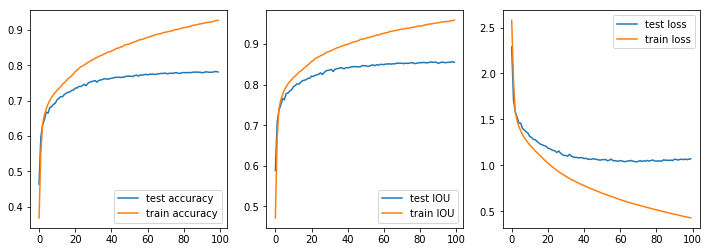

---------------------------------------------------------------------------------------------------- 



In [11]:
f = stats([tst], [trn], ephocs=100, params=[200])

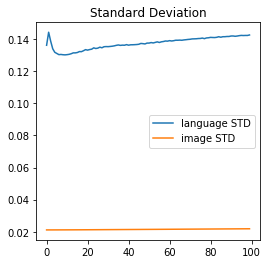

In [13]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD_list, imgSTD_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

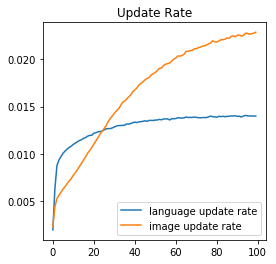

In [12]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention CDND

prefix attention + CDN + Dropout

In [12]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'RL/EXP/attnCDN1'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=100, dropout_in=1, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/attnCDN1
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.76 ;acc:0.21 ;iou:0.30 ;qMean:-0.00 ;qSTD:0.10 ;iMean:-0.00 ;iSTD:0.02 ;qRange:0.56 ;iRange:0.13 ;Gq:0.09541 ;Gi:0.16353 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.67 ;acc:0.36 ;iou:0.49 ;qMean:-0.00 ;qSTD:0.10 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.53 ;iRange:0.13 ;Gq:0.10350 ;Gi:0.17622 ;time: 0:00:33
b:100 ;lr:0.050 ;loss:2.65 ;acc:0.38 ;iou:0.49 ;qMean:-0.00 ;qSTD:0.11 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.57 ;iRange:0.13 ;Gq:0.13063 ;Gi:0.19375 ;time: 0:01:04
b:150 ;lr:0.050 ;loss:2.60 ;acc:0.41 ;iou:0.51 ;qMean:-0.00 ;qSTD:0.12 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:0.18028 ;Gi:0.21259 ;time: 0:01:35
b:200 ;lr:0.050 ;loss:2.48 ;acc:0.51 ;iou:0.62 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:0.26446 

batch: 50 ;loss: 1.441 ;acc: 0.680 ;iou_acc: 0.720 ;time: 0:03:14
batch: 100 ;loss: 1.513 ;acc: 0.690 ;iou_acc: 0.770 ;time: 0:03:24
batch: 150 ;loss: 1.582 ;acc: 0.630 ;iou_acc: 0.705 ;time: 0:03:35
batch: 200 ;loss: 1.361 ;acc: 0.660 ;iou_acc: 0.760 ;time: 0:03:44
batch: 250 ;loss: 1.589 ;acc: 0.610 ;iou_acc: 0.725 ;time: 0:03:54

*Test loss: 1.448 ;Test accuracy 0.669 ;Test IOU: 0.770 ;Time: 0:04:03
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.22 ;acc:0.74 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.60 ;iRange:0.13 ;Gq:0.99401 ;Gi:0.54058 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.38 ;acc:0.70 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.60 ;iRange:0.13 ;Gq:1.08277 ;Gi:0.57144 ;time: 0:00:32
b:100 ;lr:0.050 ;loss:1.29 ;acc:0.70 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.61 ;iRange:0.13 ;Gq:1.06690 ;Gi:0.61027 ;time: 0:01:02
b:150 ;lr:0.050 ;loss:1.28 ;acc:0.76 ;iou:0.83 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.

batch: 0 ;loss: 1.165 ;acc: 0.775 ;iou_acc: 0.865 ;time: 0:03:04
batch: 50 ;loss: 1.314 ;acc: 0.725 ;iou_acc: 0.770 ;time: 0:03:14
batch: 100 ;loss: 1.327 ;acc: 0.740 ;iou_acc: 0.810 ;time: 0:03:24
batch: 150 ;loss: 1.464 ;acc: 0.695 ;iou_acc: 0.770 ;time: 0:03:35
batch: 200 ;loss: 1.195 ;acc: 0.745 ;iou_acc: 0.820 ;time: 0:03:45
batch: 250 ;loss: 1.449 ;acc: 0.665 ;iou_acc: 0.765 ;time: 0:03:55

*Test loss: 1.315 ;Test accuracy 0.704 ;Test IOU: 0.798 ;Time: 0:04:04
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:1.04 ;acc:0.81 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.62 ;iRange:0.13 ;Gq:1.04241 ;Gi:0.69690 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.22 ;acc:0.72 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.61 ;iRange:0.13 ;Gq:1.15817 ;Gi:0.73354 ;time: 0:00:31
b:100 ;lr:0.050 ;loss:1.23 ;acc:0.71 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.63 ;iRange:0.13 ;Gq:1.21210 ;Gi:0.77252 ;time: 0:01:02
b:150 ;lr:0.050 ;loss:1.18 ;acc:0.77 ;


*Tr loss: 1.071 ;Tr acc: 0.773 ;IOU acc: 0.851 ;qMean:-0.000 ;qSTD:0.136 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.639 ;imgRange:0.129 ;Gq:1.20785 ;Gi:0.87195 ;Time: 0:03:02 

Testing, ephoc: 14
batch: 0 ;loss: 1.093 ;acc: 0.780 ;iou_acc: 0.860 ;time: 0:03:03
batch: 50 ;loss: 1.256 ;acc: 0.720 ;iou_acc: 0.795 ;time: 0:03:13
batch: 100 ;loss: 1.278 ;acc: 0.720 ;iou_acc: 0.790 ;time: 0:03:23
batch: 150 ;loss: 1.422 ;acc: 0.680 ;iou_acc: 0.745 ;time: 0:03:34
batch: 200 ;loss: 1.148 ;acc: 0.700 ;iou_acc: 0.770 ;time: 0:03:44
batch: 250 ;loss: 1.367 ;acc: 0.695 ;iou_acc: 0.800 ;time: 0:03:54

*Test loss: 1.253 ;Test accuracy 0.720 ;Test IOU: 0.810 ;Time: 0:04:03
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:1.11 ;acc:0.72 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.64 ;iRange:0.13 ;Gq:1.20512 ;Gi:0.88827 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:1.05 ;acc:0.79 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.64 ;iRange:0.13 ;Gq:1.18221 ;Gi:0.89129 ;time: 0:00:31
b:100 ;l

b:250 ;lr:0.050 ;loss:1.03 ;acc:0.81 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.12793 ;Gi:0.93344 ;time: 0:02:38

*Tr loss: 0.972 ;Tr acc: 0.798 ;IOU acc: 0.871 ;qMean:-0.000 ;qSTD:0.139 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.658 ;imgRange:0.129 ;Gq:1.24739 ;Gi:1.02038 ;Time: 0:03:07 

Testing, ephoc: 19
batch: 0 ;loss: 1.044 ;acc: 0.795 ;iou_acc: 0.865 ;time: 0:03:07
batch: 50 ;loss: 1.199 ;acc: 0.715 ;iou_acc: 0.780 ;time: 0:03:17
batch: 100 ;loss: 1.183 ;acc: 0.765 ;iou_acc: 0.830 ;time: 0:03:27
batch: 150 ;loss: 1.346 ;acc: 0.715 ;iou_acc: 0.775 ;time: 0:03:38
batch: 200 ;loss: 1.124 ;acc: 0.735 ;iou_acc: 0.830 ;time: 0:03:48
batch: 250 ;loss: 1.317 ;acc: 0.670 ;iou_acc: 0.785 ;time: 0:03:58

*Test loss: 1.201 ;Test accuracy 0.734 ;Test IOU: 0.822 ;Time: 0:04:08
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:0.98 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.65 ;iRange:0.13 ;Gq:1.23054 ;Gi:1.09799 ;time: 0:00:00
b:50 ;l

b:200 ;lr:0.050 ;loss:0.80 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.68 ;iRange:0.13 ;Gq:1.31089 ;Gi:1.08642 ;time: 0:02:05
b:250 ;lr:0.050 ;loss:0.90 ;acc:0.82 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.67 ;iRange:0.13 ;Gq:1.25809 ;Gi:1.16446 ;time: 0:02:37

*Tr loss: 0.884 ;Tr acc: 0.821 ;IOU acc: 0.886 ;qMean:-0.000 ;qSTD:0.142 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.676 ;imgRange:0.130 ;Gq:1.27833 ;Gi:1.16619 ;Time: 0:03:05 

Testing, ephoc: 24
batch: 0 ;loss: 0.993 ;acc: 0.815 ;iou_acc: 0.880 ;time: 0:03:05
batch: 50 ;loss: 1.211 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:03:15
batch: 100 ;loss: 1.178 ;acc: 0.780 ;iou_acc: 0.850 ;time: 0:03:25
batch: 150 ;loss: 1.360 ;acc: 0.700 ;iou_acc: 0.770 ;time: 0:03:36
batch: 200 ;loss: 1.062 ;acc: 0.740 ;iou_acc: 0.825 ;time: 0:03:46
batch: 250 ;loss: 1.275 ;acc: 0.715 ;iou_acc: 0.815 ;time: 0:03:56

*Test loss: 1.170 ;Test accuracy 0.742 ;Test IOU: 0.827 ;Time: 0:04:06
Train, ephoc: 25
b:0 ;

b:150 ;lr:0.050 ;loss:0.77 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.16416 ;Gi:1.24297 ;time: 0:01:35
b:200 ;lr:0.050 ;loss:0.72 ;acc:0.85 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.14899 ;Gi:1.17950 ;time: 0:02:06
b:250 ;lr:0.050 ;loss:0.89 ;acc:0.82 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.44335 ;Gi:1.42195 ;time: 0:02:36

*Tr loss: 0.800 ;Tr acc: 0.841 ;IOU acc: 0.902 ;qMean:-0.000 ;qSTD:0.145 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.693 ;imgRange:0.130 ;Gq:1.28892 ;Gi:1.28838 ;Time: 0:03:06 

Testing, ephoc: 29
batch: 0 ;loss: 0.952 ;acc: 0.820 ;iou_acc: 0.875 ;time: 0:03:06
batch: 50 ;loss: 1.165 ;acc: 0.755 ;iou_acc: 0.830 ;time: 0:03:16
batch: 100 ;loss: 1.128 ;acc: 0.760 ;iou_acc: 0.840 ;time: 0:03:26
batch: 150 ;loss: 1.341 ;acc: 0.715 ;iou_acc: 0.765 ;time: 0:03:37
batch: 200 ;loss: 1.067 ;acc: 0.735 ;iou_acc: 0.835 ;time: 0:03:47
ba

b:100 ;lr:0.045 ;loss:0.72 ;acc:0.88 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.39283 ;Gi:1.54200 ;time: 0:01:03
b:150 ;lr:0.045 ;loss:0.80 ;acc:0.85 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.69 ;iRange:0.13 ;Gq:1.36031 ;Gi:1.39132 ;time: 0:01:34
b:200 ;lr:0.045 ;loss:0.70 ;acc:0.84 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.29063 ;Gi:1.39964 ;time: 0:02:05
b:250 ;lr:0.045 ;loss:0.68 ;acc:0.85 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.27674 ;Gi:1.43031 ;time: 0:02:38

*Tr loss: 0.728 ;Tr acc: 0.859 ;IOU acc: 0.914 ;qMean:-0.001 ;qSTD:0.148 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.706 ;imgRange:0.130 ;Gq:1.29219 ;Gi:1.38137 ;Time: 0:03:04 

Testing, ephoc: 34
batch: 0 ;loss: 0.933 ;acc: 0.800 ;iou_acc: 0.870 ;time: 0:03:05
batch: 50 ;loss: 1.187 ;acc: 0.730 ;iou_acc: 0.815 ;time: 0:03:15
batch: 100 ;loss: 1.083 ;acc: 0.775 ;iou_acc

b:50 ;lr:0.045 ;loss:0.65 ;acc:0.87 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.28565 ;Gi:1.47108 ;time: 0:00:32
b:100 ;lr:0.045 ;loss:0.60 ;acc:0.89 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.31085 ;Gi:1.50190 ;time: 0:01:02
b:150 ;lr:0.045 ;loss:0.65 ;acc:0.86 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.34722 ;Gi:1.64755 ;time: 0:01:33
b:200 ;lr:0.045 ;loss:0.67 ;acc:0.90 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.71 ;iRange:0.13 ;Gq:1.29947 ;Gi:1.44379 ;time: 0:02:07
b:250 ;lr:0.045 ;loss:0.65 ;acc:0.88 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.29531 ;Gi:1.58251 ;time: 0:02:37

*Tr loss: 0.668 ;Tr acc: 0.873 ;IOU acc: 0.923 ;qMean:-0.001 ;qSTD:0.150 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.720 ;imgRange:0.130 ;Gq:1.31275 ;Gi:1.47293 ;Time: 0:03:05 

Testing, ephoc: 39
batch: 0 ;loss: 0

b:0 ;lr:0.045 ;loss:0.68 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.28248 ;Gi:1.59830 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.47 ;acc:0.92 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.22214 ;Gi:1.35363 ;time: 0:00:32
b:100 ;lr:0.045 ;loss:0.58 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.33827 ;Gi:1.45466 ;time: 0:01:03
b:150 ;lr:0.045 ;loss:0.76 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.64339 ;Gi:1.93348 ;time: 0:01:34
b:200 ;lr:0.045 ;loss:0.53 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:1.30425 ;Gi:1.54398 ;time: 0:02:06
b:250 ;lr:0.045 ;loss:0.57 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.73 ;iRange:0.13 ;Gq:1.26020 ;Gi:1.39722 ;time: 0:02:39

*Tr loss: 0.616 ;Tr acc: 0.886 ;IOU acc: 0.932 ;


*Test loss: 1.128 ;Test accuracy 0.766 ;Test IOU: 0.844 ;Time: 0:04:07
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.49 ;acc:0.93 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.08623 ;Gi:1.24834 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.61 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.30463 ;Gi:1.55992 ;time: 0:00:31
b:100 ;lr:0.045 ;loss:0.53 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.27165 ;Gi:1.75537 ;time: 0:01:01
b:150 ;lr:0.045 ;loss:0.66 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.45679 ;Gi:1.87741 ;time: 0:01:31
b:200 ;lr:0.045 ;loss:0.55 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.74 ;iRange:0.13 ;Gq:1.25821 ;Gi:1.57805 ;time: 0:02:03
b:250 ;lr:0.045 ;loss:0.47 ;acc:0.94 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13

batch: 150 ;loss: 1.398 ;acc: 0.730 ;iou_acc: 0.795 ;time: 0:03:36
batch: 200 ;loss: 0.960 ;acc: 0.780 ;iou_acc: 0.865 ;time: 0:03:46
batch: 250 ;loss: 1.207 ;acc: 0.720 ;iou_acc: 0.825 ;time: 0:03:56

*Test loss: 1.131 ;Test accuracy 0.767 ;Test IOU: 0.846 ;Time: 0:04:06
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.46 ;acc:0.94 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.17622 ;Gi:1.35974 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.53 ;acc:0.90 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.32452 ;Gi:1.63407 ;time: 0:00:32
b:100 ;lr:0.045 ;loss:0.42 ;acc:0.95 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:1.16032 ;Gi:1.55584 ;time: 0:01:03
b:150 ;lr:0.045 ;loss:0.45 ;acc:0.93 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.29349 ;Gi:1.66753 ;time: 0:01:35
b:200 ;lr:0.045 ;loss:0.64 ;acc:0.87 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean

batch: 0 ;loss: 0.931 ;acc: 0.820 ;iou_acc: 0.860 ;time: 0:03:06
batch: 50 ;loss: 1.156 ;acc: 0.745 ;iou_acc: 0.845 ;time: 0:03:16
batch: 100 ;loss: 1.084 ;acc: 0.790 ;iou_acc: 0.865 ;time: 0:03:26
batch: 150 ;loss: 1.424 ;acc: 0.715 ;iou_acc: 0.765 ;time: 0:03:36
batch: 200 ;loss: 0.970 ;acc: 0.765 ;iou_acc: 0.860 ;time: 0:03:47
batch: 250 ;loss: 1.196 ;acc: 0.750 ;iou_acc: 0.855 ;time: 0:03:58

*Test loss: 1.145 ;Test accuracy 0.770 ;Test IOU: 0.847 ;Time: 0:04:07
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.52 ;acc:0.90 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.76 ;iRange:0.13 ;Gq:1.32988 ;Gi:1.66925 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.40 ;acc:0.94 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.77 ;iRange:0.13 ;Gq:1.09810 ;Gi:1.34456 ;time: 0:00:35
b:100 ;lr:0.045 ;loss:0.59 ;acc:0.87 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.77 ;iRange:0.13 ;Gq:1.38412 ;Gi:1.80606 ;time: 0:01:03
b:150 ;lr:0.045 ;loss:0.56 ;acc:0.91 ;


*Tr loss: 0.449 ;Tr acc: 0.926 ;IOU acc: 0.958 ;qMean:-0.001 ;qSTD:0.160 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.775 ;imgRange:0.132 ;Gq:1.28527 ;Gi:1.67448 ;Time: 0:03:05 

Testing, ephoc: 63
batch: 0 ;loss: 0.973 ;acc: 0.800 ;iou_acc: 0.870 ;time: 0:03:06
batch: 50 ;loss: 1.207 ;acc: 0.760 ;iou_acc: 0.840 ;time: 0:03:16
batch: 100 ;loss: 1.141 ;acc: 0.805 ;iou_acc: 0.875 ;time: 0:03:26
batch: 150 ;loss: 1.471 ;acc: 0.715 ;iou_acc: 0.765 ;time: 0:03:37
batch: 200 ;loss: 0.990 ;acc: 0.810 ;iou_acc: 0.880 ;time: 0:03:47
batch: 250 ;loss: 1.227 ;acc: 0.735 ;iou_acc: 0.845 ;time: 0:03:57

*Test loss: 1.174 ;Test accuracy 0.769 ;Test IOU: 0.847 ;Time: 0:04:07
Train, ephoc: 64
b:0 ;lr:0.045 ;loss:0.43 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.41405 ;Gi:1.82653 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.40 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.28145 ;Gi:1.54858 ;time: 0:00:31
b:100 ;l

b:250 ;lr:0.040 ;loss:0.33 ;acc:0.96 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.21148 ;Gi:1.59419 ;time: 0:02:37

*Tr loss: 0.411 ;Tr acc: 0.935 ;IOU acc: 0.963 ;qMean:-0.001 ;qSTD:0.162 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.786 ;imgRange:0.132 ;Gq:1.24617 ;Gi:1.65832 ;Time: 0:03:05 

Testing, ephoc: 68
batch: 0 ;loss: 0.939 ;acc: 0.815 ;iou_acc: 0.880 ;time: 0:03:05
batch: 50 ;loss: 1.146 ;acc: 0.765 ;iou_acc: 0.860 ;time: 0:03:15
batch: 100 ;loss: 1.103 ;acc: 0.790 ;iou_acc: 0.880 ;time: 0:03:26
batch: 150 ;loss: 1.498 ;acc: 0.710 ;iou_acc: 0.765 ;time: 0:03:36
batch: 200 ;loss: 0.980 ;acc: 0.770 ;iou_acc: 0.870 ;time: 0:03:46
batch: 250 ;loss: 1.180 ;acc: 0.725 ;iou_acc: 0.850 ;time: 0:03:56

*Test loss: 1.162 ;Test accuracy 0.771 ;Test IOU: 0.848 ;Time: 0:04:05
Train, ephoc: 69
b:0 ;lr:0.040 ;loss:0.48 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.24746 ;Gi:1.76953 ;time: 0:00:01
b:50 ;l

b:200 ;lr:0.040 ;loss:0.31 ;acc:0.98 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.80 ;iRange:0.13 ;Gq:1.15956 ;Gi:1.59005 ;time: 0:02:05
b:250 ;lr:0.040 ;loss:0.39 ;acc:0.95 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.79 ;iRange:0.13 ;Gq:1.34651 ;Gi:1.67469 ;time: 0:02:37

*Tr loss: 0.380 ;Tr acc: 0.943 ;IOU acc: 0.968 ;qMean:-0.001 ;qSTD:0.164 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.796 ;imgRange:0.132 ;Gq:1.23630 ;Gi:1.66753 ;Time: 0:03:04 

Testing, ephoc: 73
batch: 0 ;loss: 0.936 ;acc: 0.825 ;iou_acc: 0.880 ;time: 0:03:05
batch: 50 ;loss: 1.210 ;acc: 0.770 ;iou_acc: 0.845 ;time: 0:03:15
batch: 100 ;loss: 1.115 ;acc: 0.780 ;iou_acc: 0.870 ;time: 0:03:25
batch: 150 ;loss: 1.499 ;acc: 0.720 ;iou_acc: 0.765 ;time: 0:03:36
batch: 200 ;loss: 0.993 ;acc: 0.805 ;iou_acc: 0.885 ;time: 0:03:46
batch: 250 ;loss: 1.209 ;acc: 0.745 ;iou_acc: 0.860 ;time: 0:03:56

*Test loss: 1.186 ;Test accuracy 0.772 ;Test IOU: 0.850 ;Time: 0:04:05
Train, ephoc: 74
b:0 ;

b:150 ;lr:0.040 ;loss:0.37 ;acc:0.94 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.81 ;iRange:0.13 ;Gq:1.28736 ;Gi:1.66767 ;time: 0:01:33
b:200 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.81 ;iRange:0.13 ;Gq:1.20032 ;Gi:1.55020 ;time: 0:02:06
b:250 ;lr:0.040 ;loss:0.38 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.81 ;iRange:0.13 ;Gq:1.16709 ;Gi:1.48292 ;time: 0:02:36

*Tr loss: 0.348 ;Tr acc: 0.949 ;IOU acc: 0.973 ;qMean:-0.001 ;qSTD:0.166 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.806 ;imgRange:0.132 ;Gq:1.21112 ;Gi:1.65275 ;Time: 0:03:05 

Testing, ephoc: 78
batch: 0 ;loss: 0.939 ;acc: 0.820 ;iou_acc: 0.885 ;time: 0:03:05
batch: 50 ;loss: 1.168 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:03:16
batch: 100 ;loss: 1.104 ;acc: 0.795 ;iou_acc: 0.870 ;time: 0:03:26
batch: 150 ;loss: 1.562 ;acc: 0.710 ;iou_acc: 0.770 ;time: 0:03:37
batch: 200 ;loss: 1.026 ;acc: 0.790 ;iou_acc: 0.880 ;time: 0:03:46
ba

b:100 ;lr:0.040 ;loss:0.27 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.15657 ;Gi:1.57716 ;time: 0:01:05
b:150 ;lr:0.040 ;loss:0.25 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.00644 ;Gi:1.38601 ;time: 0:01:36
b:200 ;lr:0.040 ;loss:0.35 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.31786 ;Gi:1.81525 ;time: 0:02:08
b:250 ;lr:0.040 ;loss:0.31 ;acc:0.94 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.81 ;iRange:0.13 ;Gq:1.53701 ;Gi:1.99958 ;time: 0:02:37

*Tr loss: 0.322 ;Tr acc: 0.955 ;IOU acc: 0.975 ;qMean:-0.001 ;qSTD:0.168 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.815 ;imgRange:0.133 ;Gq:1.18570 ;Gi:1.64211 ;Time: 0:03:07 

Testing, ephoc: 83
batch: 0 ;loss: 0.997 ;acc: 0.815 ;iou_acc: 0.880 ;time: 0:03:08
batch: 50 ;loss: 1.234 ;acc: 0.760 ;iou_acc: 0.855 ;time: 0:03:17
batch: 100 ;loss: 1.181 ;acc: 0.780 ;iou_acc

b:50 ;lr:0.040 ;loss:0.20 ;acc:0.99 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:0.96637 ;Gi:1.27099 ;time: 0:00:32
b:100 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.21662 ;Gi:1.76104 ;time: 0:01:03
b:150 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:1.23974 ;Gi:1.87462 ;time: 0:01:35
b:200 ;lr:0.040 ;loss:0.25 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.12637 ;Gi:1.65982 ;time: 0:02:06
b:250 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.19844 ;Gi:1.65334 ;time: 0:02:39

*Tr loss: 0.296 ;Tr acc: 0.960 ;IOU acc: 0.979 ;qMean:-0.001 ;qSTD:0.170 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.824 ;imgRange:0.133 ;Gq:1.15940 ;Gi:1.61699 ;Time: 0:03:06 

Testing, ephoc: 88
batch: 0 ;loss: 0

b:0 ;lr:0.040 ;loss:0.31 ;acc:0.95 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.49821 ;Gi:1.89318 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.27 ;acc:0.98 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:1.17398 ;Gi:1.67120 ;time: 0:00:32
b:100 ;lr:0.040 ;loss:0.25 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:1.06513 ;Gi:1.41586 ;time: 0:01:02
b:150 ;lr:0.040 ;loss:0.20 ;acc:0.99 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.01859 ;Gi:1.30906 ;time: 0:01:35
b:200 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.31577 ;Gi:1.80856 ;time: 0:02:04
b:250 ;lr:0.040 ;loss:0.31 ;acc:0.96 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.25938 ;Gi:1.60729 ;time: 0:02:37

*Tr loss: 0.270 ;Tr acc: 0.965 ;IOU acc: 0.982 ;


*Test loss: 1.290 ;Test accuracy 0.772 ;Test IOU: 0.848 ;Time: 0:04:05
Train, ephoc: 98
b:0 ;lr:0.040 ;loss:0.24 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.10755 ;Gi:1.59755 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.34 ;acc:0.93 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.14 ;Gq:1.22882 ;Gi:1.64527 ;time: 0:00:32
b:100 ;lr:0.040 ;loss:0.17 ;acc:0.98 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:0.83815 ;Gi:1.14406 ;time: 0:01:03
b:150 ;lr:0.040 ;loss:0.26 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:1.05564 ;Gi:1.82935 ;time: 0:01:35
b:200 ;lr:0.040 ;loss:0.24 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.13 ;Gq:1.03232 ;Gi:1.29724 ;time: 0:02:07
b:250 ;lr:0.040 ;loss:0.27 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13

Train accuracy:0.970
Test accuracy:0.773
Train P@1:0.985
Test P@1:0.850
Train loss loss:0.244
Test loss loss:1.110


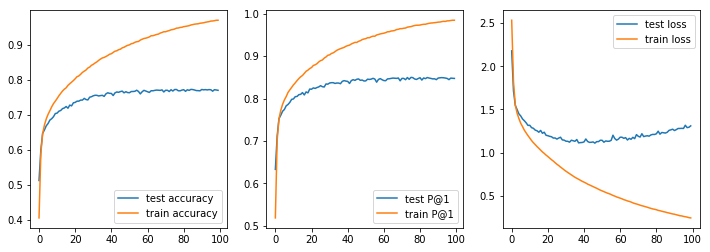

---------------------------------------------------------------------------------------------------- 



In [15]:
f = stats([tst], [trn], ephocs=100, params=[1])

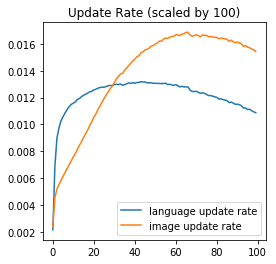

In [17]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()

## Attention and Bi

Bidirectional RNN + prefix attention + CDN + Dropout

In [8]:
tf.reset_defaulrd=0
params_dir = params_dir_tmp+'RL/EXP/attnBiCDN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    Qscale=0.16,
    use_wordAttn=True,
    useBidirectionalRnn=True,
    IMGscale=0.023)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=100, dropout_in=1, dropout_out=1)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/attnBiCDN
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.70 ;acc:0.21 ;iou:0.33 ;qMean:-0.00 ;qSTD:0.13 ;iMean:-0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:0.10843 ;Gi:0.18282 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.65 ;acc:0.38 ;iou:0.46 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.70 ;iRange:0.13 ;Gq:0.12880 ;Gi:0.19126 ;time: 0:00:47
b:100 ;lr:0.050 ;loss:2.66 ;acc:0.41 ;iou:0.51 ;qMean:0.00 ;qSTD:0.13 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.72 ;iRange:0.13 ;Gq:0.16350 ;Gi:0.19242 ;time: 0:01:30
b:150 ;lr:0.050 ;loss:2.61 ;acc:0.44 ;iou:0.55 ;qMean:0.00 ;qSTD:0.14 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.75 ;iRange:0.13 ;Gq:0.22145 ;Gi:0.22139 ;time: 0:02:15
b:200 ;lr:0.050 ;loss:2.30 ;acc:0.53 ;iou:0.68 ;qMean:0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.79 ;iRange:0.13 ;Gq:0.30302 ;Gi

batch: 50 ;loss: 1.461 ;acc: 0.665 ;iou_acc: 0.745 ;time: 0:04:24
batch: 100 ;loss: 1.462 ;acc: 0.665 ;iou_acc: 0.755 ;time: 0:04:37
batch: 150 ;loss: 1.591 ;acc: 0.660 ;iou_acc: 0.730 ;time: 0:04:51
batch: 200 ;loss: 1.317 ;acc: 0.705 ;iou_acc: 0.795 ;time: 0:05:04
batch: 250 ;loss: 1.491 ;acc: 0.645 ;iou_acc: 0.760 ;time: 0:05:17

*Test loss: 1.416 ;Test accuracy 0.677 ;Test IOU: 0.776 ;Time: 0:05:30
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:1.23 ;acc:0.73 ;iou:0.81 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.77 ;iRange:0.13 ;Gq:0.92696 ;Gi:0.61850 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:1.46 ;acc:0.66 ;iou:0.77 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.77 ;iRange:0.13 ;Gq:1.08704 ;Gi:0.64459 ;time: 0:00:45
b:100 ;lr:0.050 ;loss:1.31 ;acc:0.72 ;iou:0.80 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.77 ;iRange:0.13 ;Gq:0.98834 ;Gi:0.70094 ;time: 0:01:26
b:150 ;lr:0.050 ;loss:1.21 ;acc:0.75 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.

Testing, ephoc: 9
batch: 0 ;loss: 1.159 ;acc: 0.765 ;iou_acc: 0.845 ;time: 0:04:15
batch: 50 ;loss: 1.332 ;acc: 0.720 ;iou_acc: 0.770 ;time: 0:04:27
batch: 100 ;loss: 1.330 ;acc: 0.700 ;iou_acc: 0.785 ;time: 0:04:40
batch: 150 ;loss: 1.482 ;acc: 0.670 ;iou_acc: 0.745 ;time: 0:04:54
batch: 200 ;loss: 1.163 ;acc: 0.710 ;iou_acc: 0.795 ;time: 0:05:07
batch: 250 ;loss: 1.381 ;acc: 0.680 ;iou_acc: 0.760 ;time: 0:05:20

*Test loss: 1.285 ;Test accuracy 0.711 ;Test IOU: 0.802 ;Time: 0:05:32
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:0.99 ;acc:0.81 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.00949 ;Gi:0.79665 ;time: 0:00:02
b:50 ;lr:0.050 ;loss:1.14 ;acc:0.79 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.79 ;iRange:0.13 ;Gq:0.98458 ;Gi:0.67704 ;time: 0:00:45
b:100 ;lr:0.050 ;loss:1.19 ;acc:0.74 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.78 ;iRange:0.13 ;Gq:1.08351 ;Gi:0.76806 ;time: 0:01:27
b:150 ;lr:0.050 ;los


*Tr loss: 0.995 ;Tr acc: 0.792 ;IOU acc: 0.865 ;qMean:-0.000 ;qSTD:0.151 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.801 ;imgRange:0.129 ;Gq:1.10332 ;Gi:0.88110 ;Time: 0:04:15 

Testing, ephoc: 14
batch: 0 ;loss: 1.048 ;acc: 0.770 ;iou_acc: 0.840 ;time: 0:04:15
batch: 50 ;loss: 1.323 ;acc: 0.725 ;iou_acc: 0.780 ;time: 0:04:28
batch: 100 ;loss: 1.242 ;acc: 0.705 ;iou_acc: 0.800 ;time: 0:04:41
batch: 150 ;loss: 1.347 ;acc: 0.720 ;iou_acc: 0.790 ;time: 0:04:55
batch: 200 ;loss: 1.091 ;acc: 0.765 ;iou_acc: 0.835 ;time: 0:05:08
batch: 250 ;loss: 1.300 ;acc: 0.675 ;iou_acc: 0.780 ;time: 0:05:21

*Test loss: 1.210 ;Test accuracy 0.731 ;Test IOU: 0.818 ;Time: 0:05:33
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:0.93 ;acc:0.80 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.80 ;iRange:0.13 ;Gq:1.11234 ;Gi:0.86669 ;time: 0:00:02
b:50 ;lr:0.050 ;loss:1.02 ;acc:0.79 ;iou:0.85 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.80 ;iRange:0.13 ;Gq:1.18165 ;Gi:0.99263 ;time: 0:00:43
b:100 ;l

b:250 ;lr:0.050 ;loss:0.88 ;acc:0.81 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.09808 ;Gi:0.96255 ;time: 0:03:35

*Tr loss: 0.876 ;Tr acc: 0.822 ;IOU acc: 0.886 ;qMean:-0.000 ;qSTD:0.153 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.815 ;imgRange:0.130 ;Gq:1.14463 ;Gi:1.02426 ;Time: 0:04:14 

Testing, ephoc: 19
batch: 0 ;loss: 0.985 ;acc: 0.800 ;iou_acc: 0.865 ;time: 0:04:14
batch: 50 ;loss: 1.256 ;acc: 0.740 ;iou_acc: 0.815 ;time: 0:04:27
batch: 100 ;loss: 1.205 ;acc: 0.720 ;iou_acc: 0.810 ;time: 0:04:40
batch: 150 ;loss: 1.312 ;acc: 0.740 ;iou_acc: 0.795 ;time: 0:04:53
batch: 200 ;loss: 1.061 ;acc: 0.755 ;iou_acc: 0.835 ;time: 0:05:06
batch: 250 ;loss: 1.224 ;acc: 0.695 ;iou_acc: 0.820 ;time: 0:05:19

*Test loss: 1.159 ;Test accuracy 0.747 ;Test IOU: 0.830 ;Time: 0:05:31
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:0.75 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.82 ;iRange:0.13 ;Gq:1.09053 ;Gi:0.95445 ;time: 0:00:01
b:50 ;l

b:200 ;lr:0.050 ;loss:0.65 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.84 ;iRange:0.13 ;Gq:0.99597 ;Gi:1.06107 ;time: 0:02:52
b:250 ;lr:0.050 ;loss:0.86 ;acc:0.81 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.32400 ;Gi:1.19568 ;time: 0:03:35

*Tr loss: 0.777 ;Tr acc: 0.848 ;IOU acc: 0.906 ;qMean:-0.000 ;qSTD:0.154 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.829 ;imgRange:0.130 ;Gq:1.17362 ;Gi:1.15622 ;Time: 0:04:16 

Testing, ephoc: 24
batch: 0 ;loss: 0.992 ;acc: 0.780 ;iou_acc: 0.860 ;time: 0:04:16
batch: 50 ;loss: 1.284 ;acc: 0.710 ;iou_acc: 0.780 ;time: 0:04:29
batch: 100 ;loss: 1.148 ;acc: 0.740 ;iou_acc: 0.815 ;time: 0:04:42
batch: 150 ;loss: 1.313 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:04:55
batch: 200 ;loss: 0.993 ;acc: 0.785 ;iou_acc: 0.860 ;time: 0:05:07
batch: 250 ;loss: 1.262 ;acc: 0.700 ;iou_acc: 0.820 ;time: 0:05:20

*Test loss: 1.130 ;Test accuracy 0.753 ;Test IOU: 0.834 ;Time: 0:05:32
Train, ephoc: 25
b:0 ;

b:150 ;lr:0.050 ;loss:0.68 ;acc:0.87 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.33778 ;Gi:1.42469 ;time: 0:02:12
b:200 ;lr:0.050 ;loss:0.66 ;acc:0.87 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.13 ;Gq:1.22458 ;Gi:1.29961 ;time: 0:02:52
b:250 ;lr:0.050 ;loss:0.76 ;acc:0.87 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.15 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.83 ;iRange:0.13 ;Gq:1.35633 ;Gi:1.46939 ;time: 0:03:36

*Tr loss: 0.688 ;Tr acc: 0.869 ;IOU acc: 0.921 ;qMean:-0.000 ;qSTD:0.155 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.840 ;imgRange:0.130 ;Gq:1.18547 ;Gi:1.26230 ;Time: 0:04:15 

Testing, ephoc: 29
batch: 0 ;loss: 0.913 ;acc: 0.825 ;iou_acc: 0.895 ;time: 0:04:16
batch: 50 ;loss: 1.234 ;acc: 0.750 ;iou_acc: 0.820 ;time: 0:04:28
batch: 100 ;loss: 1.147 ;acc: 0.760 ;iou_acc: 0.840 ;time: 0:04:41
batch: 150 ;loss: 1.256 ;acc: 0.730 ;iou_acc: 0.805 ;time: 0:04:55
batch: 200 ;loss: 0.986 ;acc: 0.795 ;iou_acc: 0.870 ;time: 0:05:08
ba

b:100 ;lr:0.045 ;loss:0.73 ;acc:0.84 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.13 ;Gq:1.37003 ;Gi:1.60024 ;time: 0:01:26
b:150 ;lr:0.045 ;loss:0.64 ;acc:0.89 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.13 ;Gq:1.11120 ;Gi:1.22664 ;time: 0:02:09
b:200 ;lr:0.045 ;loss:0.60 ;acc:0.90 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.85 ;iRange:0.13 ;Gq:1.11911 ;Gi:1.36523 ;time: 0:02:54
b:250 ;lr:0.045 ;loss:0.69 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.87 ;iRange:0.13 ;Gq:1.30538 ;Gi:1.35169 ;time: 0:03:35

*Tr loss: 0.613 ;Tr acc: 0.889 ;IOU acc: 0.935 ;qMean:-0.000 ;qSTD:0.157 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.855 ;imgRange:0.130 ;Gq:1.18160 ;Gi:1.34357 ;Time: 0:04:16 

Testing, ephoc: 34
batch: 0 ;loss: 0.900 ;acc: 0.825 ;iou_acc: 0.910 ;time: 0:04:16
batch: 50 ;loss: 1.272 ;acc: 0.730 ;iou_acc: 0.790 ;time: 0:04:30
batch: 100 ;loss: 1.121 ;acc: 0.760 ;iou_acc

b:50 ;lr:0.045 ;loss:0.39 ;acc:0.95 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.87 ;iRange:0.13 ;Gq:1.00871 ;Gi:1.25952 ;time: 0:00:44
b:100 ;lr:0.045 ;loss:0.52 ;acc:0.91 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.86 ;iRange:0.13 ;Gq:1.11314 ;Gi:1.19044 ;time: 0:01:27
b:150 ;lr:0.045 ;loss:0.52 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.17996 ;Gi:1.28369 ;time: 0:02:09
b:200 ;lr:0.045 ;loss:0.50 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.86 ;iRange:0.13 ;Gq:1.14118 ;Gi:1.28541 ;time: 0:02:52
b:250 ;lr:0.045 ;loss:0.61 ;acc:0.88 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.36433 ;Gi:1.59249 ;time: 0:03:38

*Tr loss: 0.549 ;Tr acc: 0.904 ;IOU acc: 0.945 ;qMean:-0.000 ;qSTD:0.158 ;iMean:0.000 ;iSTD:0.021 ;qRange:0.868 ;imgRange:0.131 ;Gq:1.17896 ;Gi:1.40060 ;Time: 0:04:15 

Testing, ephoc: 39
batch: 0 ;loss: 0

b:0 ;lr:0.045 ;loss:0.53 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.07154 ;Gi:1.19362 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.54 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.86 ;iRange:0.13 ;Gq:1.23197 ;Gi:1.55641 ;time: 0:00:44
b:100 ;lr:0.045 ;loss:0.60 ;acc:0.91 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.18386 ;Gi:1.36584 ;time: 0:01:26
b:150 ;lr:0.045 ;loss:0.51 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.12770 ;Gi:1.49070 ;time: 0:02:05
b:200 ;lr:0.045 ;loss:0.60 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.87 ;iRange:0.13 ;Gq:1.24988 ;Gi:1.57008 ;time: 0:02:49
b:250 ;lr:0.045 ;loss:0.55 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.88 ;iRange:0.13 ;Gq:1.36473 ;Gi:1.65018 ;time: 0:03:31

*Tr loss: 0.495 ;Tr acc: 0.917 ;IOU acc: 0.952 ;


*Test loss: 1.144 ;Test accuracy 0.767 ;Test IOU: 0.844 ;Time: 0:05:34
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.58 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.89 ;iRange:0.13 ;Gq:1.21545 ;Gi:1.61184 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.48 ;acc:0.92 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.90 ;iRange:0.13 ;Gq:1.11698 ;Gi:1.52474 ;time: 0:00:42
b:100 ;lr:0.045 ;loss:0.43 ;acc:0.93 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.89 ;iRange:0.13 ;Gq:1.26911 ;Gi:1.43329 ;time: 0:01:26
b:150 ;lr:0.045 ;loss:0.34 ;acc:0.96 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.89 ;iRange:0.13 ;Gq:0.94991 ;Gi:1.16433 ;time: 0:02:10
b:200 ;lr:0.045 ;loss:0.46 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.89 ;iRange:0.13 ;Gq:1.16214 ;Gi:1.42569 ;time: 0:02:53
b:250 ;lr:0.045 ;loss:0.44 ;acc:0.92 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.90 ;iRange:0.13

batch: 150 ;loss: 1.313 ;acc: 0.745 ;iou_acc: 0.810 ;time: 0:04:52
batch: 200 ;loss: 1.094 ;acc: 0.765 ;iou_acc: 0.855 ;time: 0:05:05
batch: 250 ;loss: 1.351 ;acc: 0.730 ;iou_acc: 0.850 ;time: 0:05:18

*Test loss: 1.184 ;Test accuracy 0.765 ;Test IOU: 0.842 ;Time: 0:05:30
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.36 ;acc:0.95 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.90 ;iRange:0.13 ;Gq:1.25335 ;Gi:1.53608 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.52 ;acc:0.94 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.90 ;iRange:0.13 ;Gq:1.20141 ;Gi:1.47705 ;time: 0:00:42
b:100 ;lr:0.045 ;loss:0.39 ;acc:0.95 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.91 ;iRange:0.13 ;Gq:1.06214 ;Gi:1.44771 ;time: 0:01:24
b:150 ;lr:0.045 ;loss:0.39 ;acc:0.95 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.91 ;iRange:0.13 ;Gq:1.19772 ;Gi:1.50954 ;time: 0:02:07
b:200 ;lr:0.045 ;loss:0.42 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.16 ;iMean

batch: 0 ;loss: 0.934 ;acc: 0.815 ;iou_acc: 0.880 ;time: 0:04:15
batch: 50 ;loss: 1.302 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:04:27
batch: 100 ;loss: 1.105 ;acc: 0.770 ;iou_acc: 0.850 ;time: 0:04:41
batch: 150 ;loss: 1.298 ;acc: 0.735 ;iou_acc: 0.815 ;time: 0:04:54
batch: 200 ;loss: 1.101 ;acc: 0.775 ;iou_acc: 0.855 ;time: 0:05:07
batch: 250 ;loss: 1.298 ;acc: 0.720 ;iou_acc: 0.865 ;time: 0:05:20

*Test loss: 1.158 ;Test accuracy 0.773 ;Test IOU: 0.849 ;Time: 0:05:32
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.35 ;acc:0.97 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.91 ;iRange:0.13 ;Gq:1.00550 ;Gi:1.74136 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.42 ;acc:0.93 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.91 ;iRange:0.13 ;Gq:1.29124 ;Gi:1.88301 ;time: 0:00:45
b:100 ;lr:0.045 ;loss:0.44 ;acc:0.92 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.92 ;iRange:0.13 ;Gq:1.12096 ;Gi:1.66002 ;time: 0:01:28
b:150 ;lr:0.045 ;loss:0.33 ;acc:0.94 ;


*Tr loss: 0.317 ;Tr acc: 0.958 ;IOU acc: 0.978 ;qMean:-0.000 ;qSTD:0.165 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.920 ;imgRange:0.132 ;Gq:1.08970 ;Gi:1.46952 ;Time: 0:04:10 

Testing, ephoc: 63
batch: 0 ;loss: 0.904 ;acc: 0.805 ;iou_acc: 0.885 ;time: 0:04:11
batch: 50 ;loss: 1.313 ;acc: 0.715 ;iou_acc: 0.800 ;time: 0:04:23
batch: 100 ;loss: 1.129 ;acc: 0.765 ;iou_acc: 0.835 ;time: 0:04:35
batch: 150 ;loss: 1.331 ;acc: 0.720 ;iou_acc: 0.820 ;time: 0:04:49
batch: 200 ;loss: 1.196 ;acc: 0.775 ;iou_acc: 0.835 ;time: 0:05:02
batch: 250 ;loss: 1.429 ;acc: 0.710 ;iou_acc: 0.845 ;time: 0:05:14

*Test loss: 1.196 ;Test accuracy 0.774 ;Test IOU: 0.850 ;Time: 0:05:26
Train, ephoc: 64
b:0 ;lr:0.045 ;loss:0.36 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.16 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.92 ;iRange:0.13 ;Gq:1.15846 ;Gi:1.59219 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.26 ;acc:0.97 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.92 ;iRange:0.13 ;Gq:0.99971 ;Gi:1.31591 ;time: 0:00:44
b:100 ;l

b:250 ;lr:0.040 ;loss:0.24 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.92 ;iRange:0.13 ;Gq:0.92949 ;Gi:1.16778 ;time: 0:03:32

*Tr loss: 0.278 ;Tr acc: 0.965 ;IOU acc: 0.983 ;qMean:-0.000 ;qSTD:0.166 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.932 ;imgRange:0.132 ;Gq:1.01824 ;Gi:1.40059 ;Time: 0:04:13 

Testing, ephoc: 68
batch: 0 ;loss: 0.935 ;acc: 0.840 ;iou_acc: 0.910 ;time: 0:04:14
batch: 50 ;loss: 1.322 ;acc: 0.720 ;iou_acc: 0.790 ;time: 0:04:27
batch: 100 ;loss: 1.142 ;acc: 0.800 ;iou_acc: 0.860 ;time: 0:04:39
batch: 150 ;loss: 1.479 ;acc: 0.725 ;iou_acc: 0.795 ;time: 0:04:53
batch: 200 ;loss: 1.187 ;acc: 0.775 ;iou_acc: 0.850 ;time: 0:05:06
batch: 250 ;loss: 1.398 ;acc: 0.705 ;iou_acc: 0.850 ;time: 0:05:20

*Test loss: 1.222 ;Test accuracy 0.774 ;Test IOU: 0.850 ;Time: 0:05:32
Train, ephoc: 69
b:0 ;lr:0.040 ;loss:0.20 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.94 ;iRange:0.13 ;Gq:0.86740 ;Gi:1.16976 ;time: 0:00:01
b:50 ;l

b:200 ;lr:0.040 ;loss:0.22 ;acc:0.99 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.94 ;iRange:0.13 ;Gq:0.86899 ;Gi:1.24710 ;time: 0:02:48
b:250 ;lr:0.040 ;loss:0.28 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.95 ;iRange:0.13 ;Gq:1.09184 ;Gi:1.58362 ;time: 0:03:33

*Tr loss: 0.249 ;Tr acc: 0.970 ;IOU acc: 0.986 ;qMean:-0.000 ;qSTD:0.168 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.941 ;imgRange:0.132 ;Gq:0.99466 ;Gi:1.38016 ;Time: 0:04:14 

Testing, ephoc: 73
batch: 0 ;loss: 0.913 ;acc: 0.830 ;iou_acc: 0.900 ;time: 0:04:14
batch: 50 ;loss: 1.316 ;acc: 0.735 ;iou_acc: 0.805 ;time: 0:04:27
batch: 100 ;loss: 1.185 ;acc: 0.775 ;iou_acc: 0.845 ;time: 0:04:40
batch: 150 ;loss: 1.450 ;acc: 0.735 ;iou_acc: 0.800 ;time: 0:04:54
batch: 200 ;loss: 1.235 ;acc: 0.795 ;iou_acc: 0.860 ;time: 0:05:07
batch: 250 ;loss: 1.379 ;acc: 0.730 ;iou_acc: 0.865 ;time: 0:05:20

*Test loss: 1.250 ;Test accuracy 0.773 ;Test IOU: 0.848 ;Time: 0:05:32
Train, ephoc: 74
b:0 ;

b:150 ;lr:0.040 ;loss:0.18 ;acc:0.99 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.95 ;iRange:0.13 ;Gq:0.89666 ;Gi:1.13171 ;time: 0:02:11
b:200 ;lr:0.040 ;loss:0.32 ;acc:0.96 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:1.25220 ;Gi:1.59869 ;time: 0:02:53
b:250 ;lr:0.040 ;loss:0.19 ;acc:0.98 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.95 ;iRange:0.13 ;Gq:0.91131 ;Gi:1.15272 ;time: 0:03:35

*Tr loss: 0.217 ;Tr acc: 0.977 ;IOU acc: 0.989 ;qMean:-0.000 ;qSTD:0.169 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.951 ;imgRange:0.133 ;Gq:0.93294 ;Gi:1.31826 ;Time: 0:04:13 

Testing, ephoc: 78
batch: 0 ;loss: 0.963 ;acc: 0.805 ;iou_acc: 0.875 ;time: 0:04:14
batch: 50 ;loss: 1.384 ;acc: 0.725 ;iou_acc: 0.795 ;time: 0:04:27
batch: 100 ;loss: 1.215 ;acc: 0.780 ;iou_acc: 0.840 ;time: 0:04:40
batch: 150 ;loss: 1.412 ;acc: 0.735 ;iou_acc: 0.810 ;time: 0:04:54
batch: 200 ;loss: 1.283 ;acc: 0.775 ;iou_acc: 0.850 ;time: 0:05:06
ba

b:100 ;lr:0.040 ;loss:0.11 ;acc:1.00 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.63354 ;Gi:0.79269 ;time: 0:01:27
b:150 ;lr:0.040 ;loss:0.17 ;acc:0.98 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:0.89230 ;Gi:1.24561 ;time: 0:02:12
b:200 ;lr:0.040 ;loss:0.20 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:0.88335 ;Gi:1.31651 ;time: 0:02:54
b:250 ;lr:0.040 ;loss:0.19 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.95 ;iRange:0.13 ;Gq:0.79187 ;Gi:1.09315 ;time: 0:03:36

*Tr loss: 0.195 ;Tr acc: 0.980 ;IOU acc: 0.991 ;qMean:-0.000 ;qSTD:0.170 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.959 ;imgRange:0.133 ;Gq:0.90034 ;Gi:1.28163 ;Time: 0:04:15 

Testing, ephoc: 83
batch: 0 ;loss: 0.995 ;acc: 0.815 ;iou_acc: 0.890 ;time: 0:04:15
batch: 50 ;loss: 1.428 ;acc: 0.715 ;iou_acc: 0.805 ;time: 0:04:28
batch: 100 ;loss: 1.260 ;acc: 0.760 ;iou_acc

b:50 ;lr:0.040 ;loss:0.19 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:0.95612 ;Gi:1.45178 ;time: 0:00:43
b:100 ;lr:0.040 ;loss:0.16 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:0.78829 ;Gi:0.97606 ;time: 0:01:25
b:150 ;lr:0.040 ;loss:0.20 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.99805 ;Gi:1.71102 ;time: 0:02:07
b:200 ;lr:0.040 ;loss:0.22 ;acc:0.96 ;iou:0.97 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:1.01103 ;Gi:1.53290 ;time: 0:02:48
b:250 ;lr:0.040 ;loss:0.16 ;acc:0.99 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.96 ;iRange:0.13 ;Gq:0.93166 ;Gi:1.28061 ;time: 0:03:36

*Tr loss: 0.173 ;Tr acc: 0.984 ;IOU acc: 0.993 ;qMean:-0.000 ;qSTD:0.171 ;iMean:0.000 ;iSTD:0.022 ;qRange:0.967 ;imgRange:0.133 ;Gq:0.86512 ;Gi:1.24213 ;Time: 0:04:17 

Testing, ephoc: 88
batch: 0 ;loss: 1

b:0 ;lr:0.040 ;loss:0.24 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.14 ;Gq:0.91944 ;Gi:1.18514 ;time: 0:00:02
b:50 ;lr:0.040 ;loss:0.10 ;acc:1.00 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.69632 ;Gi:0.98111 ;time: 0:00:43
b:100 ;lr:0.040 ;loss:0.15 ;acc:1.00 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.74050 ;Gi:1.19297 ;time: 0:01:24
b:150 ;lr:0.040 ;loss:0.12 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.70431 ;Gi:1.17460 ;time: 0:02:07
b:200 ;lr:0.040 ;loss:0.14 ;acc:1.00 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.86367 ;Gi:1.19892 ;time: 0:02:50
b:250 ;lr:0.040 ;loss:0.12 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.13 ;Gq:0.76852 ;Gi:1.22673 ;time: 0:03:34

*Tr loss: 0.153 ;Tr acc: 0.987 ;IOU acc: 0.994 ;


*Test loss: 1.401 ;Test accuracy 0.773 ;Test IOU: 0.848 ;Time: 0:05:33
Train, ephoc: 98
b:0 ;lr:0.040 ;loss:0.15 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.13 ;Gq:0.75526 ;Gi:0.90041 ;time: 0:00:01
b:50 ;lr:0.040 ;loss:0.13 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.13 ;Gq:0.79174 ;Gi:1.15819 ;time: 0:00:45
b:100 ;lr:0.040 ;loss:0.14 ;acc:0.98 ;iou:1.00 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.13 ;Gq:0.70769 ;Gi:0.98645 ;time: 0:01:29
b:150 ;lr:0.040 ;loss:0.21 ;acc:0.98 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:1.00 ;iRange:0.13 ;Gq:0.90435 ;Gi:1.27668 ;time: 0:02:12
b:200 ;lr:0.040 ;loss:0.11 ;acc:0.99 ;iou:0.99 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.97 ;iRange:0.13 ;Gq:0.59968 ;Gi:1.09211 ;time: 0:02:57
b:250 ;lr:0.040 ;loss:0.19 ;acc:0.97 ;iou:0.98 ;qMean:-0.00 ;qSTD:0.17 ;iMean:0.00 ;iSTD:0.02 ;qRange:0.98 ;iRange:0.13

In [9]:
np.save(open('../data/training/results/AttBiCDND_tst.bin', 'wb'), tst)
np.save(open('../data/training/results/AttBiCDND_trn.bin', 'wb'), trn)
np.save(open('../data/training/results/AttBiCDND_imgMean.bin', 'wb'), imgMean_list)
np.save(open('../data/training/results/AttBiCDND_imgSTD.bin', 'wb'), imgSTD_list)
np.save(open('../data/training/results/AttBiCDND_imgRange.bin', 'wb'), imgRange_list)
np.save(open('../data/training/results/AttBiCDND_qMean.bin', 'wb'), qMean_list)
np.save(open('../data/training/results/AttBiCDND_qSTD.bin', 'wb'), qSTD_list)
np.save(open('../data/training/results/AttBiCDND_qRange.bin', 'wb'), qRange_list)
np.save(open('../data/training/results/AttBiCDND_Gq.bin', 'wb'), Gq)
np.save(open('../data/training/results/AttBiCDND_Gimg.bin', 'wb'), Gimg)

Train accuracy:0.990
Test accuracy:0.775
Train P@1:0.996
Test P@1:0.850
Train loss loss:0.131
Test loss loss:1.097


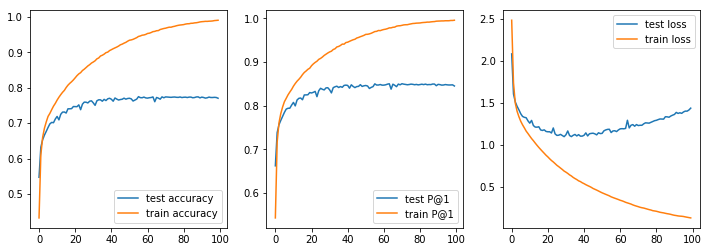

---------------------------------------------------------------------------------------------------- 



In [10]:
f = stats([tst], [trn], ephocs=100, params=[1])

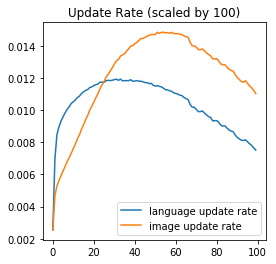

In [11]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq, Gimg]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()